# Build features for ssp scenarios

In [1]:
import os
import sys
import xarray as xr
import dask
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.interpolate import griddata


In [2]:
# Add the folder to the Python path

os.chdir("../")
# change working directory to project's root path
print(os.getcwd())

folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)
from IndexDrivers import (
    AnomaliesIndex,
    MaxIndex, 
    calculate_anomalies
)
from PredictorsDrivers import (
    Predictor
)

c:\Users\marti\Desktop\data\hw_extra


In [3]:
ua_mpi_370 = xr.open_mfdataset("data/MPI-ESM1-2-HR/ssp370/Amon/ua/*.nc", combine="by_coords", chunks={"time": 24})
ta_mpi_370 = xr.open_mfdataset("data/MPI-ESM1-2-HR/ssp370/Amon/ta/*.nc", combine="by_coords", chunks={"time": 24})
psl_mpi_370 = xr.open_mfdataset("data/MPI-ESM1-2-HR/ssp370/Amon/psl/*.nc", combine="by_coords", chunks={"time": 24})
tos_mpi_370 = xr.open_mfdataset("data/MPI-ESM1-2-HR/ssp370/Omon/tos/*.nc", combine="by_coords", chunks={"time": 24})

In [ ]:
tos_access = xr.open_mfdataset("data/01_raw/tos_Omon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc", combine="by_coords", chunks={"time": 24})
tos_canesm5 = xr.open_mfdataset("data/01_raw/tos_Omon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc", combine="by_coords", chunks={"time": 24})
tos_inm5 = xr.open_mfdataset("data/01_raw/tos_Omon_INM-CM5-0_historical_r1i1p1f1_gr1_200001-201412.nc", combine="by_coords", chunks={"time": 24})
tos_ipsl = xr.open_mfdataset("data/01_raw/tos_Omon_IPSL-CM6A-LR_ssp126_r1i1p1f1_gn_201501-210012.nc", combine="by_coords", chunks={"time": 24})
tos_mpi = xr.open_mfdataset("data/01_raw/tos_Omon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_201001-201412.nc", combine="by_coords", chunks={"time": 24})

Coordinates:
  * time     (time) datetime64[ns] 8kB 2015-01-16T12:00:00 ... 2100-12-16T12:...
  * plev     (plev) float64 152B 1e+05 9.25e+04 8.5e+04 ... 1e+03 500.0 100.0
  * lat      (lat) float64 2kB -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon      (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1

In [4]:
# ua_e3_370 = xr.open_mfdataset("data/EC-Earth3/ssp370/Amon/ua/*.nc", combine="by_coords", chunks={"time": 24})
# ta_e3_370 = xr.open_mfdataset("data/EC-Earth3/ssp370/Amon/ta/*.nc", combine="by_coords", chunks={"time": 24})
# psl_e3_370 = xr.open_mfdataset("data/EC-Earth3/ssp370/Amon/psl/*.nc", combine="by_coords", chunks={"time": 24})
# tos_e3_370 = xr.open_mfdataset("data/EC-Earth3/ssp370/Omon/tos/*.nc", combine="by_coords", chunks={"time": 24})

In [5]:
data_850 = xr.load_dataset("data/local_data/3means_850hpa_east_pacific.nc")
data_single = xr.load_dataset("data/local_data/7means_east_pacific.nc")
data_msl = xr.load_dataset("data/local_data/MSLP_east_pacific.nc")

In [6]:
ref_period = [1980,2010]

## Data processing

In [7]:
def regrid_tos_ocean_curvilinear(ds):
    tos = ds["tos"]  # (time, j, i)
    lat2d = ds["latitude"].values
    lon2d = ds["longitude"].values
    time = ds["time"]

    # === Flatten source grid and build KDTree ===
    source_points = np.column_stack((lat2d.ravel(), lon2d.ravel()))
    tree = cKDTree(source_points)

    # === Create regular grid ===
    lat_new = np.arange(-90, 90.5, 0.5)
    lon_new = np.arange(0, 360, 0.5)
    lon_grid, lat_grid = np.meshgrid(lon_new, lat_new)
    target_points = np.column_stack((lat_grid.ravel(), lon_grid.ravel()))

    # === Map target points to nearest source points ===
    _, idx = tree.query(target_points)
    j_src, i_src = np.unravel_index(idx, lat2d.shape)

    # === Use broadcasting to grab all times in one shot ===
    tos_values = tos.values + 273  # shape (time, j, i) + to Kelvin
    tos_interp = tos_values[:, j_src, i_src]  # shape (time, n_points)
    tos_interp = tos_interp.reshape(len(time), len(lat_new), len(lon_new))

    # === Build xarray Dataset ===
    tos_da = xr.DataArray(
        tos_interp,
        dims=("time", "latitude", "longitude"),
        coords={
            "time": time,
            "latitude": lat_new,
            "longitude": lon_new,
        },
        name="tos"
    )
    tos_da.attrs = ds["tos"].attrs

    tos_e3_regridded = xr.Dataset({"tos": tos_da})
    tos_e3_regridded.attrs = ds.attrs

    return tos_e3_regridded

### MPI preprocess 

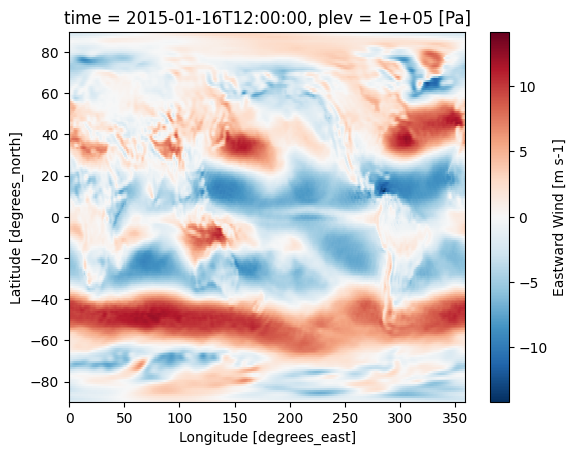

In [8]:
ua_mpi_370.isel(time=0,plev=0).ua.plot()

In [9]:
ua_mpi_370 = ua_mpi_370.rename({
    "lat": "latitude",
    "lon": "longitude"
})
ta_mpi_370 = ta_mpi_370.rename({
    "lat": "latitude",
    "lon": "longitude"
})
psl_mpi_370 = psl_mpi_370.rename({
    "lat": "latitude",
    "lon": "longitude"
})

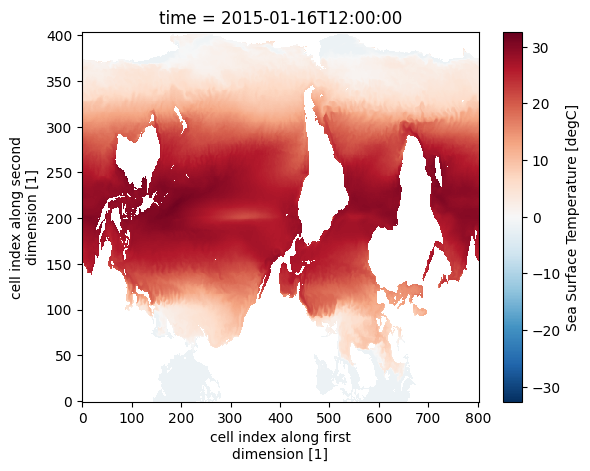

In [10]:
tos_mpi_370.isel(time=0).tos.plot()

In [11]:
tos_mpi_370_regridded = regrid_tos_ocean_curvilinear(tos_mpi_370)

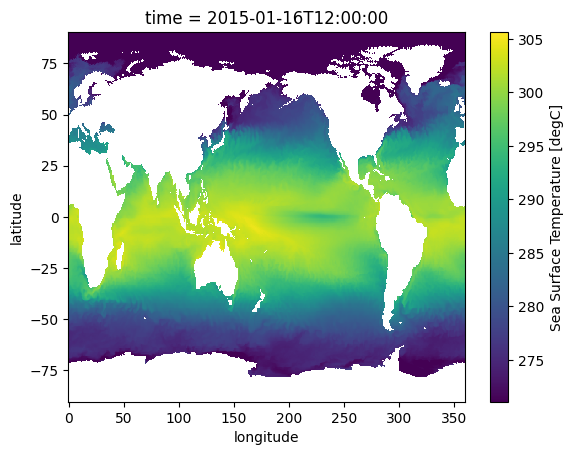

In [12]:
tos_mpi_370_regridded.isel(time=0).tos.plot()

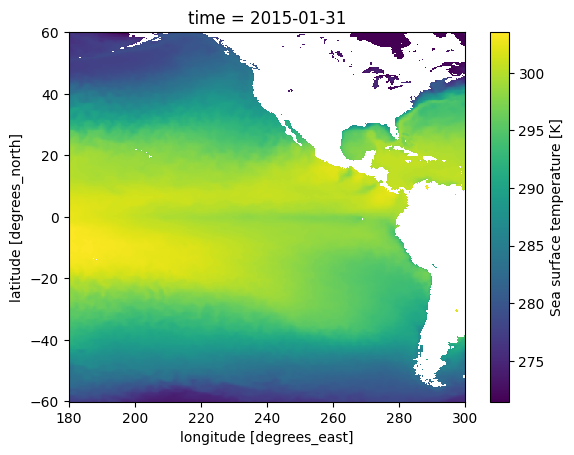

In [13]:
data_single.sel(time="2015-01").sst.plot()

### EC-Earth3 Preprocess

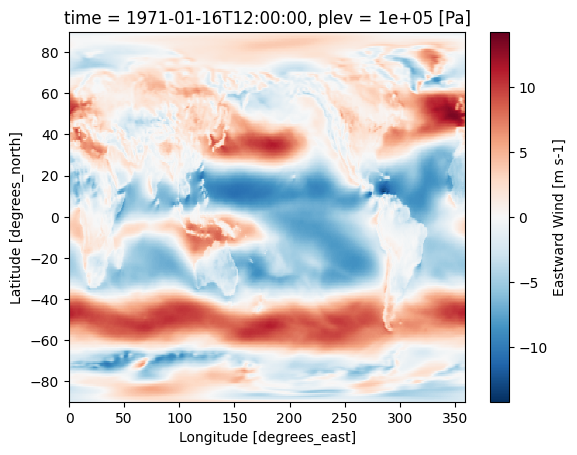

In [ ]:
ua_e3_370.isel(time=0,plev=0).ua.plot()

In [ ]:
ua_e3_370 = ua_e3_370.rename({
    "lat": "latitude",
    "lon": "longitude"
})
ta_e3_370 = ta_e3_370.rename({
    "lat": "latitude",
    "lon": "longitude"
})
psl_e3_370 = psl_e3_370.rename({
    "lat": "latitude",
    "lon": "longitude"
})

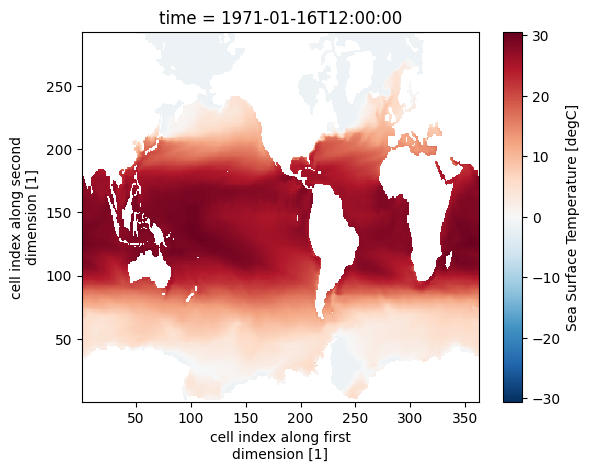

In [ ]:
tos_e3_370.isel(time=0).tos.plot()

In [ ]:
tos_e3_370_regridded = regrid_tos_ocean_curvilinear(tos_e3_370)

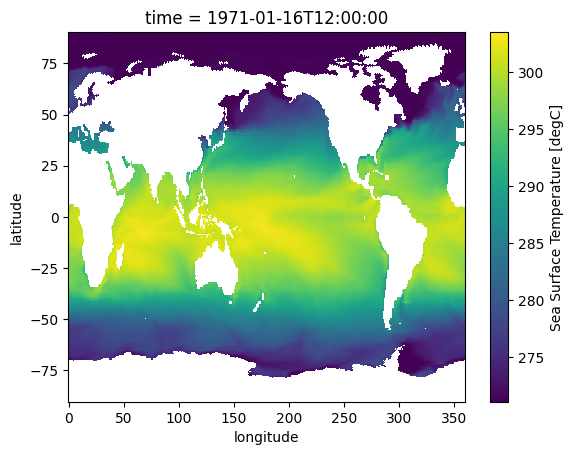

In [ ]:
tos_e3_370_regridded.isel(time=0).tos.plot()

## Features definition

In [14]:
boxes_pacific = {
    "niño3.4": [190, 240, -5, 5],  # [lon_min, lon_max, lat_min, lat_max]
    "niño1+2": [270, 280, -10, 0],
    "ocean_pressure": [260, 284, -44, -17], #study max over time and define region
    "chile" : [286, 288, -42, -33]
    #"advección": [280, 285, -37, -30]
}

In [38]:
ref_period_future = [2030,2060]
target_period_future = [2015, 2100]

In [39]:
nino34_mpi = AnomaliesIndex(tos_mpi_370_regridded, target_period_future, reference_period=ref_period_future, variables=["tos"], box_limit=boxes_pacific["niño3.4"], rolling_window=1, frequency="monthly")
nino12_mpi = AnomaliesIndex(tos_mpi_370_regridded, target_period_future, reference_period=ref_period_future, variables=["tos"], box_limit=boxes_pacific["niño1+2"], rolling_window=1, frequency="monthly")

# nino34_e3 = AnomaliesIndex(tos_e3_370_regridded, [1972,2022], reference_period=ref_period, variables=["tos"], box_limit=boxes_pacific["niño3.4"], rolling_window=1, frequency="monthly")
# nino12_e3 = AnomaliesIndex(tos_e3_370_regridded, [1972,2022], reference_period=ref_period, variables=["tos"], box_limit=boxes_pacific["niño1+2"], rolling_window=1, frequency="monthly")

nino34_era5 = AnomaliesIndex(data_single, [1972,2022], reference_period=ref_period, variables=["SST"], box_limit=boxes_pacific["niño3.4"], rolling_window=1, frequency="monthly")
nino12_era5 = AnomaliesIndex(data_single, [1972,2022], reference_period=ref_period, variables=["SST"], box_limit=boxes_pacific["niño1+2"], rolling_window=1, frequency="monthly")


In [40]:
# ocean_cyclone_gfdl = MaxIndex(psl_gfdl, [1972,2022], variables=["psl"], box_limit=boxes_pacific["ocean_pressure"], anomalies=True, climatology_period=ref_period)
# ocean_cyclone_inm = MaxIndex(psl_inm, [1972,2022], variables=["psl"], box_limit=boxes_pacific["ocean_pressure"], anomalies=True, climatology_period=ref_period)
ocean_cyclone_mpi = MaxIndex(psl_mpi_370, target_period_future, variables=["psl"], box_limit=boxes_pacific["ocean_pressure"], anomalies=True, climatology_period=ref_period_future)
# ocean_cyclone_e3 = MaxIndex(psl_e3_370, [1972,2022], variables=["psl"], box_limit=boxes_pacific["ocean_pressure"], anomalies=True, climatology_period=ref_period)

ocean_cyclone_era5 = MaxIndex(data_msl, [1972,2022], variables=["MSL"], box_limit=boxes_pacific["ocean_pressure"], anomalies=True, climatology_period=ref_period)


In [41]:
boxes_chile_vaguada = {
    "b": [286, 288.5, -33, -28],
    "A_cl": [280, 286, -38,-30], #test bigger A boxes
    "A_arg": [291, 295, -38, -30]
}

In [42]:
mslp_indices_era5 = [data_msl.sel(latitude=slice(box[2],box[3]),
                           longitude=slice(box[0], box[1])
                           ).msl.mean(dim=["latitude","longitude"]) for key,box in boxes_chile_vaguada.items()]
mslp_indices_mpi_370 = [psl_mpi_370.sel(latitude=slice(box[2],box[3]),
                           longitude=slice(box[0], box[1])
                           ).psl.mean(dim=["latitude","longitude"]) for key,box in boxes_chile_vaguada.items()]
# mslp_indices_e3 = [psl_e3_370.sel(latitude=slice(box[2],box[3]),
#                            longitude=slice(box[0], box[1])
#                            ).psl.mean(dim=["latitude","longitude"]) for key,box in boxes_chile_vaguada.items()]
# mslp_indices_gfdl = [psl_gfdl.sel(latitude=slice(box[2],box[3]),
#                            longitude=slice(box[0], box[1])
#                            ).psl.mean(dim=["latitude","longitude"]) for key,box in boxes_chile_vaguada.items()]
# mslp_indices_inm = [psl_inm.sel(latitude=slice(box[2],box[3]),
#                            longitude=slice(box[0], box[1])
#                            ).psl.mean(dim=["latitude","longitude"]) for key,box in boxes_chile_vaguada.items()]

In [43]:
data_850["adv"] = -1*data_850.u*data_850.t

adv_850_mpi_370 = -1*ua_mpi_370.sel(plev=85000).ua*ta_mpi_370.sel(plev=85000).ta
adv_850_mpi_370 = xr.Dataset({"adv": adv_850_mpi_370})

# adv_850_e3_370 = -1*ua_e3_370.sel(plev=85000).ua*ta_e3_370.sel(plev=85000).ta
# adv_850_e3_370 = xr.Dataset({"adv": adv_850_e3_370})



In [44]:
boxes_chile_adv = {
    "advection_chile": [282, 286, -42, -33],
    "advection_blob": [268, 283, -32, -20]
}

In [51]:
advection_indices_mpi_370 = [AnomaliesIndex(adv_850_mpi_370, target_period_future, reference_period=ref_period_future, variables=["ADV"], box_limit=boxes_chile_adv["advection_chile"], rolling_window=1),
                     AnomaliesIndex(adv_850_mpi_370, target_period_future, reference_period=ref_period_future, variables=["ADV"], box_limit=boxes_chile_adv["advection_blob"], rolling_window=1)]
# advection_indices_e3_370 = [AnomaliesIndex(adv_850_e3_370, [1972,2022], reference_period=ref_period, variables=["ADV"], box_limit=boxes_chile_adv["advection_chile"], rolling_window=1),
#                      AnomaliesIndex(adv_850_e3_370, [1972,2022], reference_period=ref_period, variables=["ADV"], box_limit=boxes_chile_adv["advection_blob"], rolling_window=1)]
# advection_indices_gfdl = [AnomaliesIndex(adv_850_gfdl, [1972,2022], reference_period=ref_period, variables=["ADV"], box_limit=boxes_chile_adv["advection_chile"], rolling_window=1),
#                      AnomaliesIndex(adv_850_gfdl, [1972,2022], reference_period=ref_period, variables=["ADV"], box_limit=boxes_chile_adv["advection_blob"], rolling_window=1)]
# advection_indices_inm = [AnomaliesIndex(adv_850_inm, [1972,2022], reference_period=ref_period, variables=["ADV"], box_limit=boxes_chile_adv["advection_chile"], rolling_window=1),
#                      AnomaliesIndex(adv_850_inm, [1972,2022], reference_period=ref_period, variables=["ADV"], box_limit=boxes_chile_adv["advection_blob"], rolling_window=1)]
advection_indices_era5 = [AnomaliesIndex(data_850, [1972,2022], reference_period=ref_period, variables=["ADV"], box_limit=boxes_chile_adv["advection_chile"], rolling_window=1),
                     AnomaliesIndex(data_850, [1972,2022], reference_period=ref_period, variables=["ADV"], box_limit=boxes_chile_adv["advection_blob"], rolling_window=1)]

In [52]:
boxes_chile_winds = {
    "chile_u_norte": [287.5, 289.5, -37, -33],
    "chile_u_sur": [286.5, 288.5, -42, -37],
    "A_arg": [286, 292, -52, -40]
}
chile_wind_north_mpi_370 = ua_mpi_370.sel(latitude=slice(boxes_chile_winds["chile_u_norte"][2], boxes_chile_winds["chile_u_norte"][3]),
                           longitude=slice(boxes_chile_winds["chile_u_norte"][0], boxes_chile_winds["chile_u_norte"][1]), 
                           plev=85000).ua.mean(dim=["latitude","longitude"]
                           )

# chile_wind_north_e3_370 = ua_e3_370.sel(latitude=slice(boxes_chile_winds["chile_u_norte"][2], boxes_chile_winds["chile_u_norte"][3]),
#                            longitude=slice(boxes_chile_winds["chile_u_norte"][0], boxes_chile_winds["chile_u_norte"][1]), 
#                            plev=85000).ua.mean(dim=["latitude","longitude"]
#                            )

# chile_wind_north_gfdl = ua_gfdl.sel(latitude=slice(boxes_chile_winds["chile_u_norte"][2], boxes_chile_winds["chile_u_norte"][3]),
#                            longitude=slice(boxes_chile_winds["chile_u_norte"][0], boxes_chile_winds["chile_u_norte"][1]), 
#                            plev=85000).ua.mean(dim=["latitude","longitude"]
#                            )
# chile_wind_north_inm = ua_inm.sel(latitude=slice(boxes_chile_winds["chile_u_norte"][2], boxes_chile_winds["chile_u_norte"][3]),
#                            longitude=slice(boxes_chile_winds["chile_u_norte"][0], boxes_chile_winds["chile_u_norte"][1]), 
#                            plev=85000).ua.mean(dim=["latitude","longitude"]
#                            )

chile_wind_north_era5 = data_850.sel(latitude=slice(boxes_chile_winds["chile_u_norte"][2], boxes_chile_winds["chile_u_norte"][3]),
                           longitude=slice(boxes_chile_winds["chile_u_norte"][0], boxes_chile_winds["chile_u_norte"][1])
                           ).u.mean(dim=["latitude","longitude"])

chile_wind_south_mpi_370 = ua_mpi_370.sel(latitude=slice(boxes_chile_winds["chile_u_sur"][2], boxes_chile_winds["chile_u_sur"][3]),
                           longitude=slice(boxes_chile_winds["chile_u_sur"][0], boxes_chile_winds["chile_u_sur"][1]), 
                           plev=85000).ua.mean(dim=["latitude","longitude"]
                           )

# chile_wind_south_e3_370 = ua_e3_370.sel(latitude=slice(boxes_chile_winds["chile_u_sur"][2], boxes_chile_winds["chile_u_sur"][3]),
#                            longitude=slice(boxes_chile_winds["chile_u_sur"][0], boxes_chile_winds["chile_u_sur"][1]), 
#                            plev=85000).ua.mean(dim=["latitude","longitude"]
#                            )
# chile_wind_south_gfdl = ua_gfdl.sel(latitude=slice(boxes_chile_winds["chile_u_sur"][2], boxes_chile_winds["chile_u_sur"][3]),
#                            longitude=slice(boxes_chile_winds["chile_u_sur"][0], boxes_chile_winds["chile_u_sur"][1]), 
#                            plev=85000).ua.mean(dim=["latitude","longitude"]
#                            )
# chile_wind_south_inm = ua_inm.sel(latitude=slice(boxes_chile_winds["chile_u_sur"][2], boxes_chile_winds["chile_u_sur"][3]),
#                            longitude=slice(boxes_chile_winds["chile_u_sur"][0], boxes_chile_winds["chile_u_sur"][1]), 
#                            plev=85000).ua.mean(dim=["latitude","longitude"]
#                            )

chile_wind_south_era5 = data_850.sel(latitude=slice(boxes_chile_winds["chile_u_sur"][2], boxes_chile_winds["chile_u_sur"][3]),
                           longitude=slice(boxes_chile_winds["chile_u_sur"][0], boxes_chile_winds["chile_u_sur"][1])
                           ).u.mean(dim=["latitude","longitude"])


chile_wind_pressure_mpi_370 = psl_mpi_370.sel(latitude=slice(boxes_chile_winds["A_arg"][2], boxes_chile_winds["A_arg"][3]),
                           longitude=slice(boxes_chile_winds["A_arg"][0], boxes_chile_winds["A_arg"][1])).psl.mean(dim=["latitude","longitude"]
                           )

# chile_wind_pressure_e3_370 = psl_e3_370.sel(latitude=slice(boxes_chile_winds["A_arg"][2], boxes_chile_winds["A_arg"][3]),
#                            longitude=slice(boxes_chile_winds["A_arg"][0], boxes_chile_winds["A_arg"][1])).psl.mean(dim=["latitude","longitude"]
#                            )
# chile_wind_pressure_gfdl = psl_gfdl.sel(latitude=slice(boxes_chile_winds["A_arg"][2], boxes_chile_winds["A_arg"][3]),
#                            longitude=slice(boxes_chile_winds["A_arg"][0], boxes_chile_winds["A_arg"][1])).psl.mean(dim=["latitude","longitude"]
#                            )
# chile_wind_pressure_inm = psl_inm.sel(latitude=slice(boxes_chile_winds["A_arg"][2], boxes_chile_winds["A_arg"][3]),
#                            longitude=slice(boxes_chile_winds["A_arg"][0], boxes_chile_winds["A_arg"][1])).psl.mean(dim=["latitude","longitude"]
#                            )

chile_wind_pressure_era5 = data_msl.sel(latitude=slice(boxes_chile_winds["A_arg"][2], boxes_chile_winds["A_arg"][3]),
                           longitude=slice(boxes_chile_winds["A_arg"][0], boxes_chile_winds["A_arg"][1])
                           ).msl.mean(dim=["latitude","longitude"])

## Matching patterns

### Nino34 vs Advection

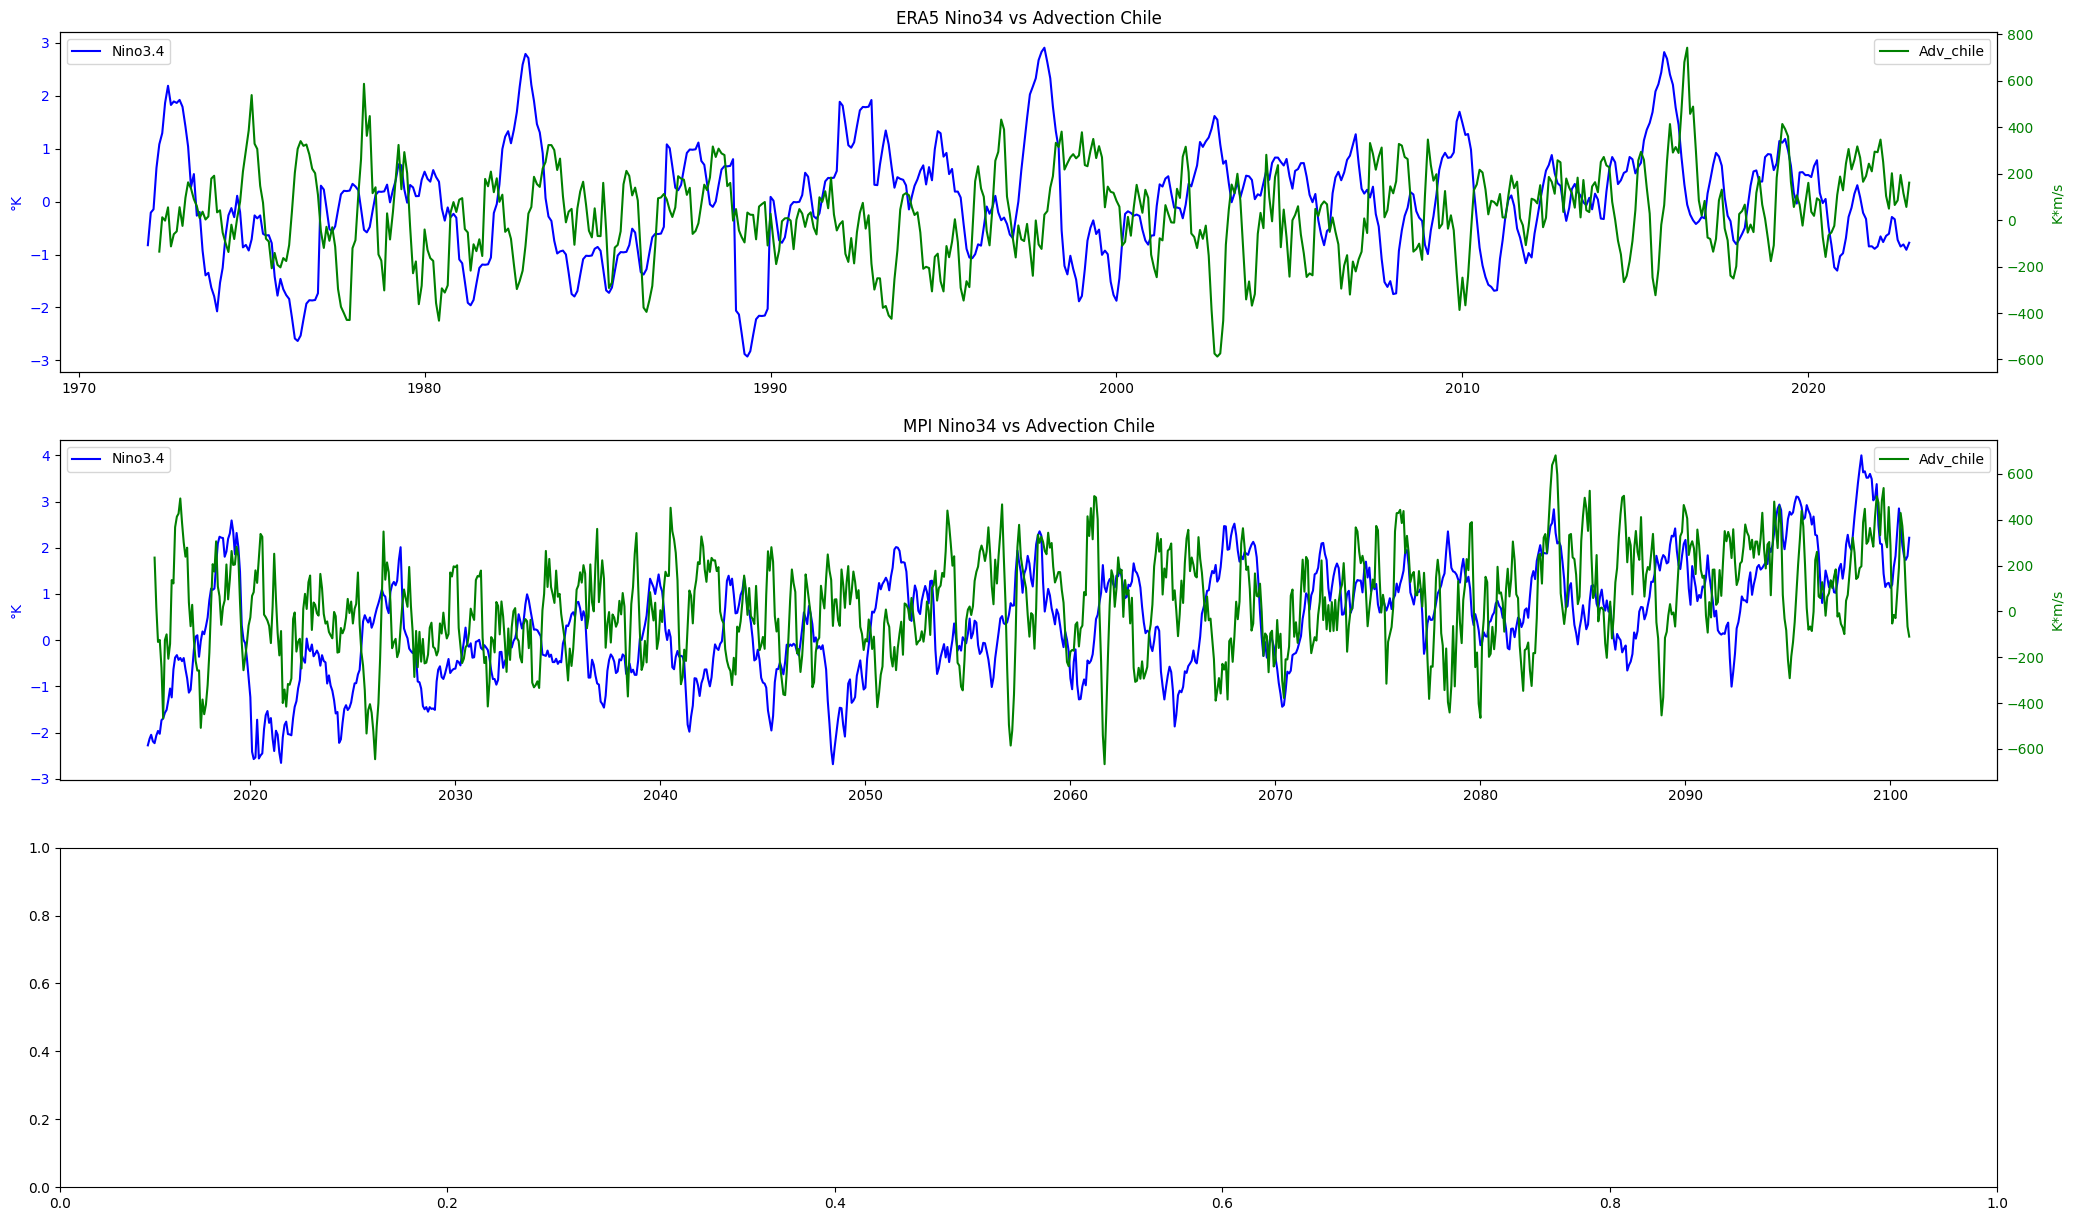

In [54]:
# Create figure and base axis
fig, ax1 = plt.subplots(3, 1, figsize=(25, 15))

ax1 = ax1.flatten()

index1_era5 = nino34_era5.get_index("SST")
index2_era5 = advection_indices_era5[0].get_index("ADV").rolling(5).mean()

# Plot first series
ax1[0].plot(index1_era5.index, index1_era5["sst"], color='blue', label='Nino3.4')
ax1[0].set_ylabel('°K', color='blue')
ax1[0].tick_params(axis='y', labelcolor='blue')

# Second Y-axis (right side)
ax2 = ax1[0].twinx()
ax2.plot(index2_era5.index, index2_era5["adv"], color='green', label='Adv_chile')
ax2.set_ylabel('K*m/s', color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax1[0].set_title("ERA5 Nino34 vs Advection Chile")
ax1[0].legend(loc='upper left')
ax2.legend(loc='upper right')

index1_mpi = nino34_mpi.get_index("tos", start_year=2015, end_year=2100)
index2_mpi = advection_indices_mpi_370[0].get_index("ADV", start_year=2015, end_year=2100).rolling(5).mean()

# Plot first series
ax1[1].plot(index1_mpi.index, index1_mpi["tos"], color='blue', label='Nino3.4')
ax1[1].set_ylabel('°K', color='blue')
ax1[1].tick_params(axis='y', labelcolor='blue')

# Second Y-axis (right side)
ax2 = ax1[1].twinx()
ax2.plot(index2_mpi.index, index2_mpi["adv"], color='green', label='Adv_chile')
ax2.set_ylabel('K*m/s', color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax1[1].set_title("MPI Nino34 vs Advection Chile")
ax1[1].legend(loc='upper left')
ax2.legend(loc='upper right')

# index1_e3 = nino34_e3.get_index("tos")
# index2_e3 = advection_indices_e3_370[0].get_index("ADV").rolling(5).mean()

# # Plot first series
# ax1[2].plot(index1_e3.index, index1_e3["tos"], color='blue', label='Nino3.4')
# ax1[2].set_ylabel('°K', color='blue')
# ax1[2].tick_params(axis='y', labelcolor='blue')

# # Second Y-axis (right side)
# ax2 = ax1[2].twinx()
# ax2.plot(index2_e3.index, index2_e3["adv"], color='green', label='Adv_chile')
# ax2.set_ylabel('K*m/s', color='green')
# ax2.tick_params(axis='y', labelcolor='green')

# ax1[2].set_title("E3 Nino34 vs Advection Chile")
# ax1[2].legend(loc='upper left')
# ax2.legend(loc='upper right')


NameError: name 'nino34_mpi_370' is not defined

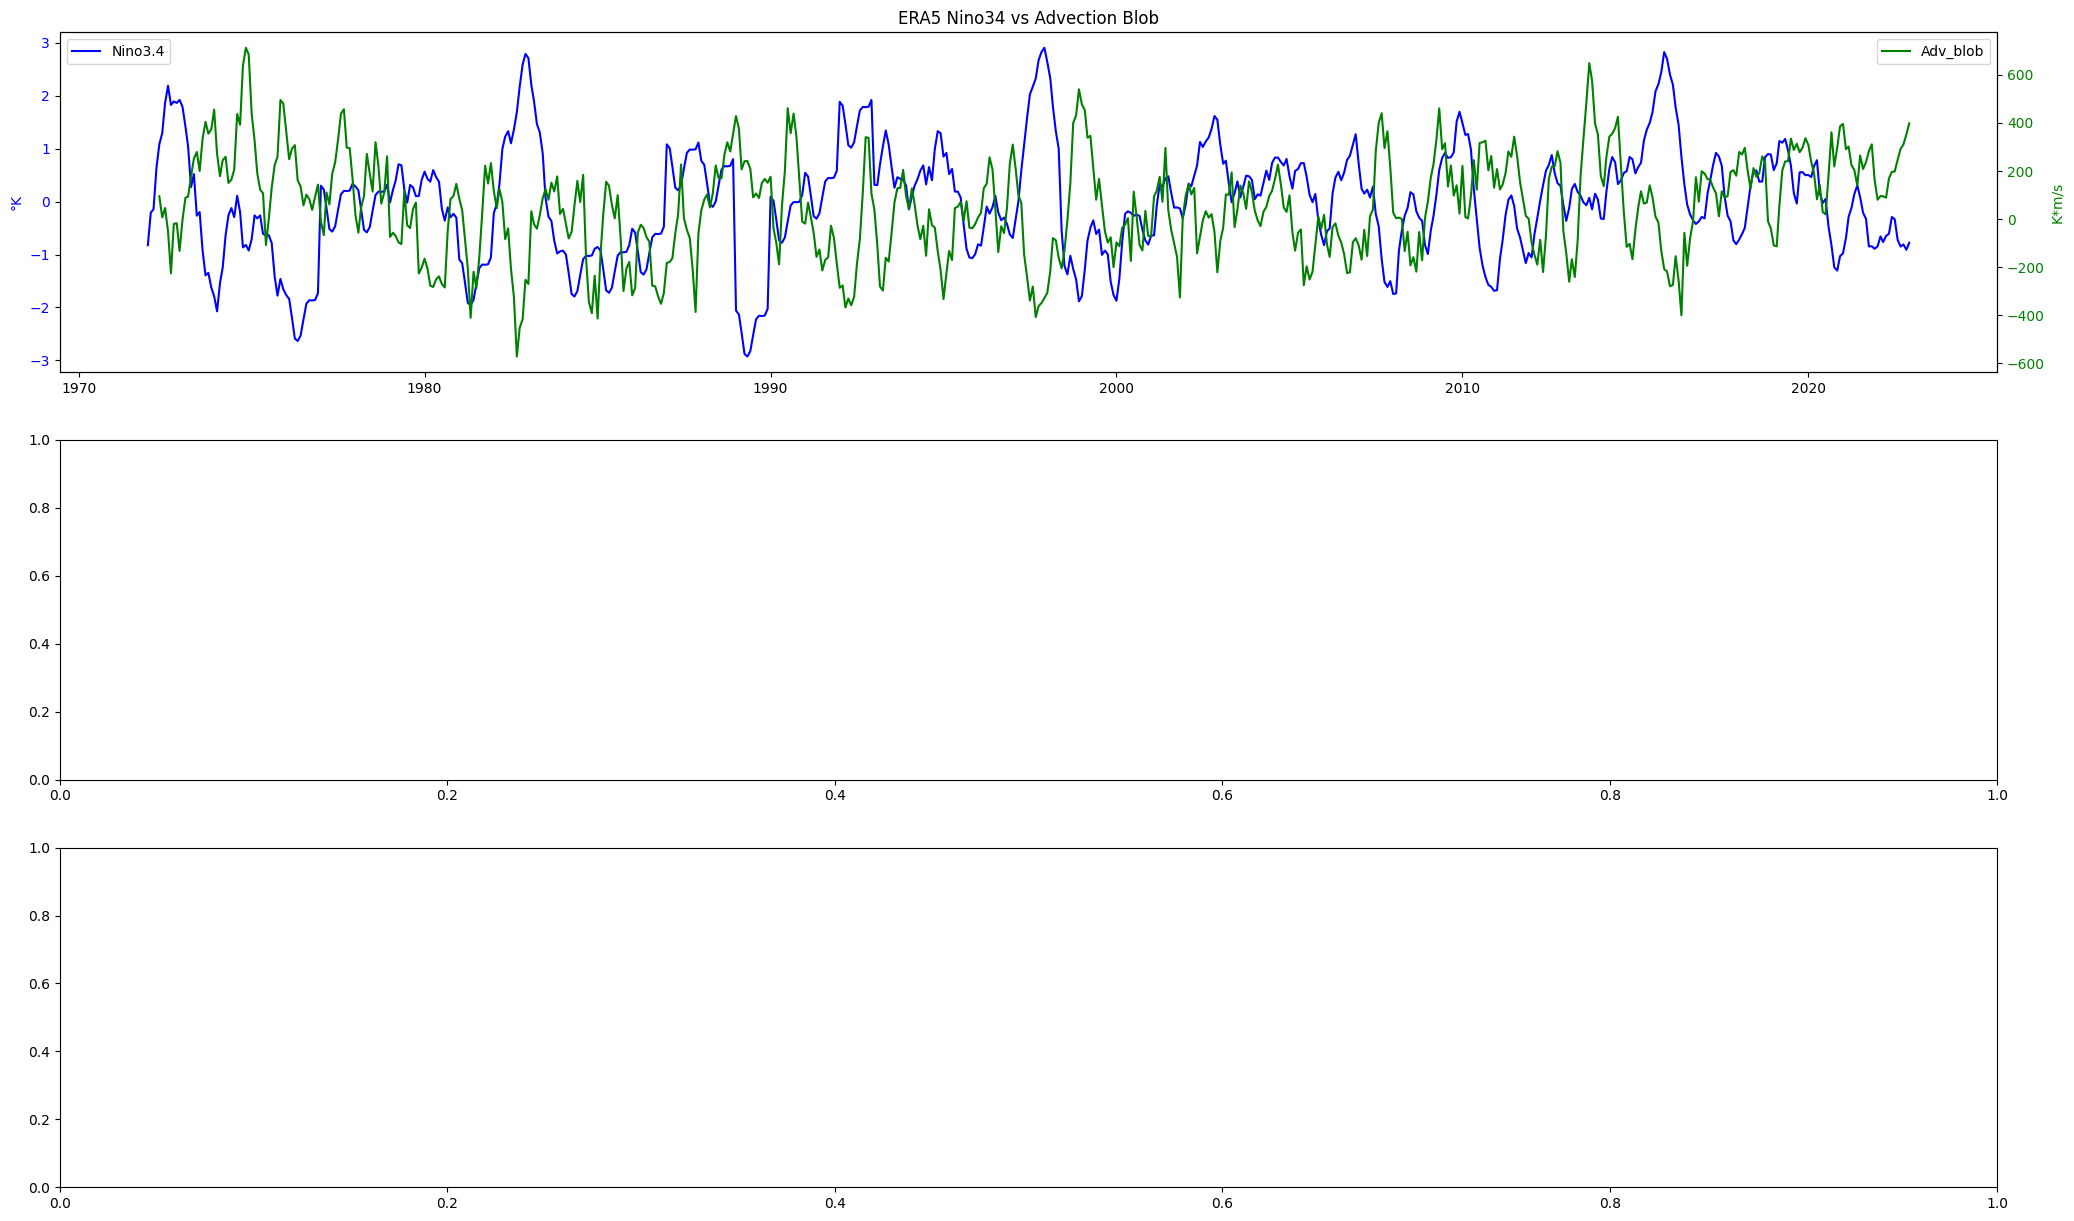

In [ ]:
# Create figure and base axis
fig, ax1 = plt.subplots(3, 1, figsize=(25, 15))

ax1 = ax1.flatten()

index1_era5 = nino34_era5.get_index("SST")
index2_era5 = advection_indices_era5[1].get_index("ADV").rolling(5).mean()

# Plot first series
ax1[0].plot(index1_era5.index, index1_era5["sst"], color='blue', label='Nino3.4')
ax1[0].set_ylabel('°K', color='blue')
ax1[0].tick_params(axis='y', labelcolor='blue')

# Second Y-axis (right side)
ax2 = ax1[0].twinx()
ax2.plot(index2_era5.index, index2_era5["adv"], color='green', label='Adv_blob')
ax2.set_ylabel('K*m/s', color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax1[0].set_title("ERA5 Nino34 vs Advection Blob")
ax1[0].legend(loc='upper left')
ax2.legend(loc='upper right')

index1_mpi = nino34_mpi.get_index("tos")
index2_mpi = advection_indices_mpi_370[1].get_index("ADV").rolling(5).mean()

# Plot first series
ax1[1].plot(index1_mpi.index, index1_mpi["tos"], color='blue', label='Nino3.4')
ax1[1].set_ylabel('°K', color='blue')
ax1[1].tick_params(axis='y', labelcolor='blue')

# Second Y-axis (right side)
ax2 = ax1[1].twinx()
ax2.plot(index2_mpi.index, index2_mpi["adv"], color='green', label='Adv_blob')
ax2.set_ylabel('K*m/s', color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax1[1].set_title("MPI Nino34 vs Advection Chile")
ax1[1].legend(loc='upper left')
ax2.legend(loc='upper right')

# index1_e3 = nino34_e3_370.get_index("tos")
# index2_e3 = advection_indices_e3_370[1].get_index("ADV").rolling(5).mean()

# # Plot first series
# ax1[2].plot(index1_e3.index, index1_e3["tos"], color='blue', label='Nino3.4')
# ax1[2].set_ylabel('°K', color='blue')
# ax1[2].tick_params(axis='y', labelcolor='blue')

# # Second Y-axis (right side)
# ax2 = ax1[2].twinx()
# ax2.plot(index2_e3.index, index2_e3["adv"], color='green', label='Adv_blob')
# ax2.set_ylabel('K*m/s', color='green')
# ax2.tick_params(axis='y', labelcolor='green')

# ax1[2].set_title("E3 Nino34 vs Advection Chile")
# ax1[2].legend(loc='upper left')
# ax2.legend(loc='upper right')



### Vaguada

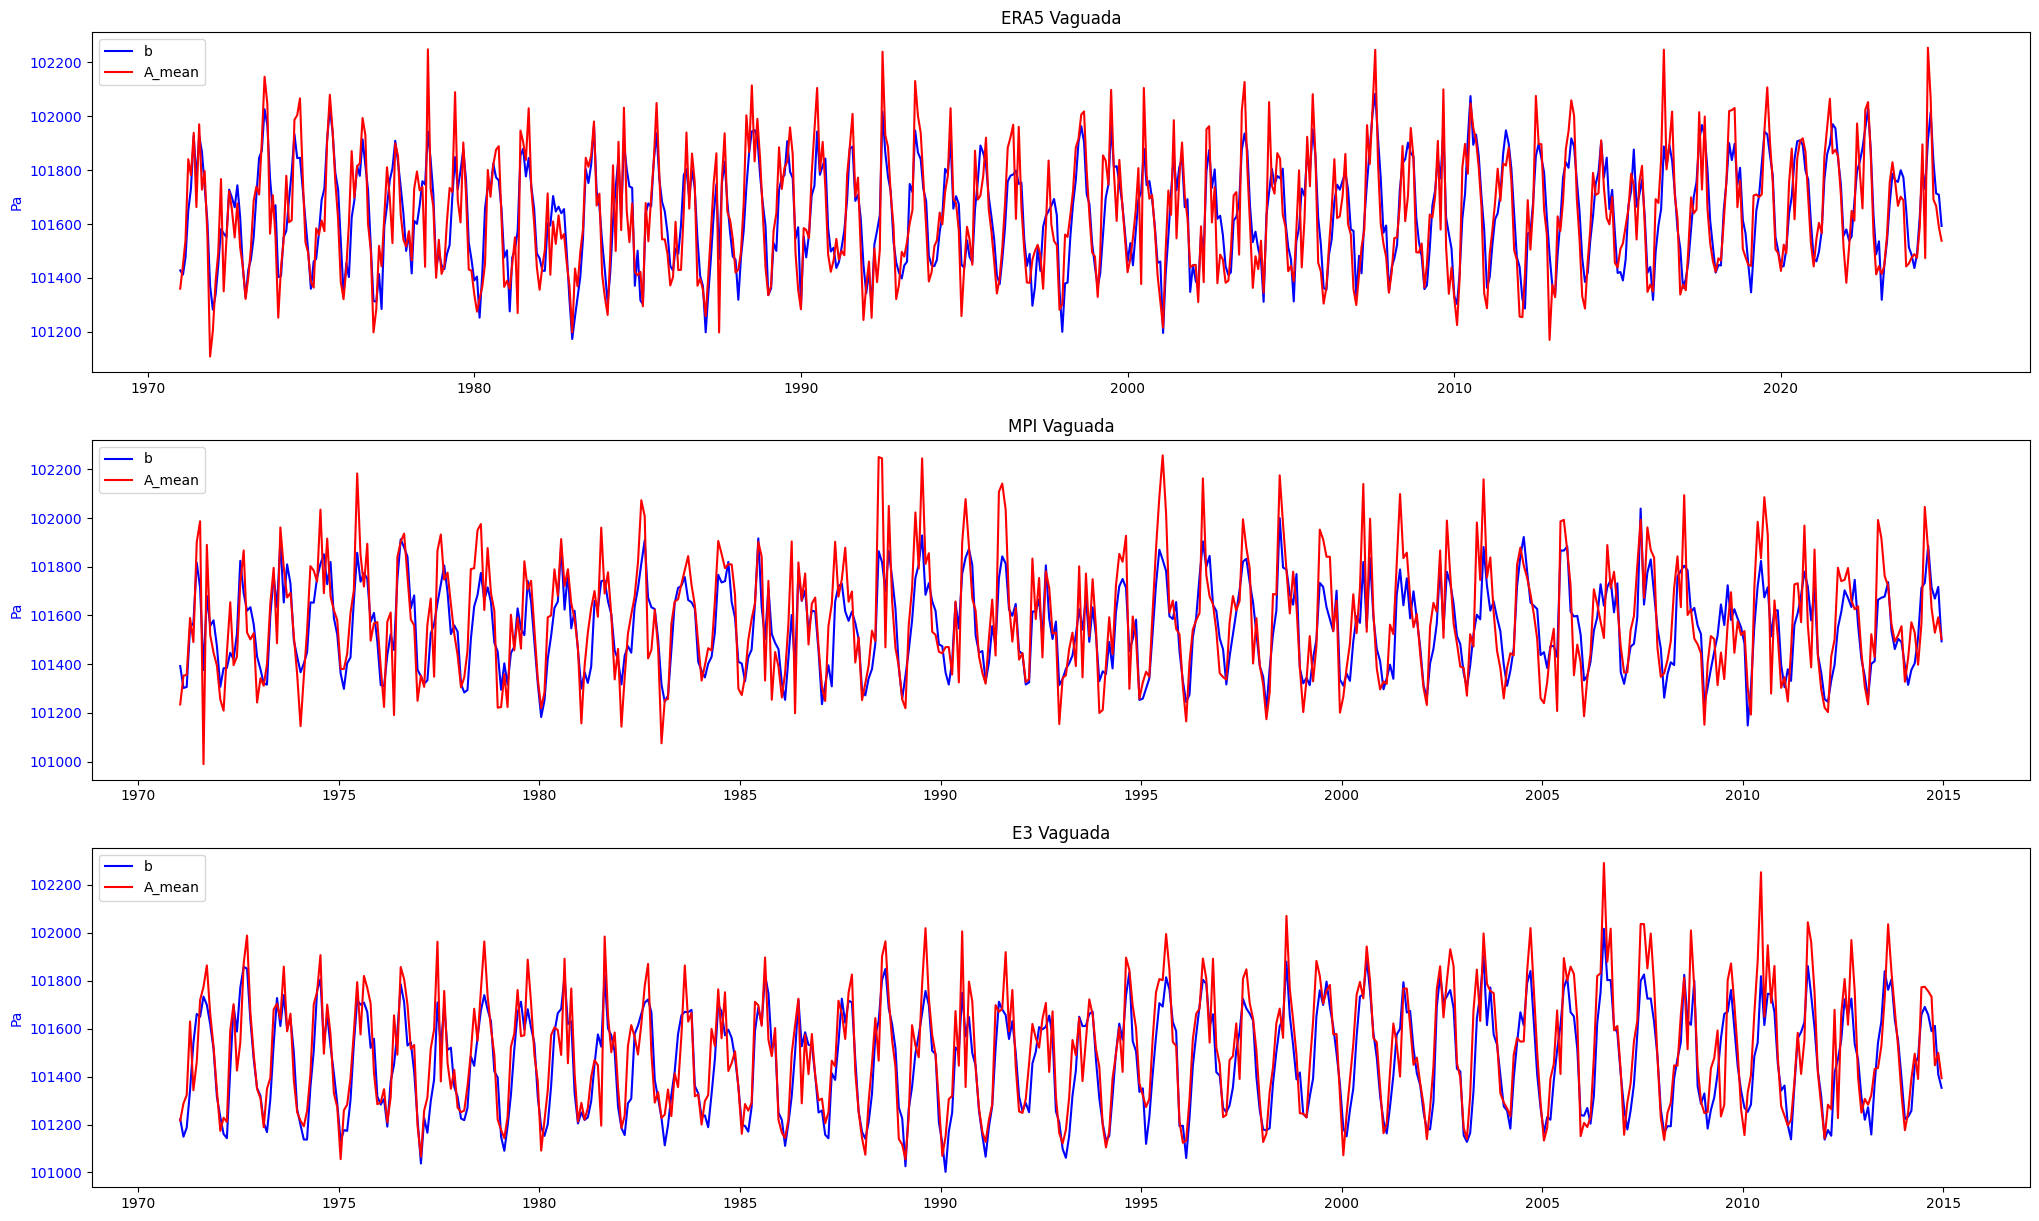

In [ ]:
# Create figure and base axis
fig, ax1 = plt.subplots(3, 1, figsize=(25, 15))

ax1 = ax1.flatten()

index1_era5 = mslp_indices_era5[0]
index2_era5 = mslp_indices_era5[1]
index3_era5 = mslp_indices_era5[2]


# Plot first series
ax1[0].plot(index1_era5.time, index1_era5, color='blue', label='b')
ax1[0].plot(index2_era5.time, (index2_era5+index3_era5)/2, color='red', label='A_mean')
ax1[0].set_ylabel('Pa', color='blue')
ax1[0].tick_params(axis='y', labelcolor='blue')

ax1[0].set_title("ERA5 Vaguada")
ax1[0].legend(loc='upper left')
ax2.legend(loc='upper right')

index1_mpi = mslp_indices_mpi_370[0]
index2_mpi = mslp_indices_mpi_370[1]
index3_mpi = mslp_indices_mpi_370[2]


# Plot first series
ax1[1].plot(index1_mpi.time, index1_mpi, color='blue', label='b')
ax1[1].plot(index2_mpi.time, (index2_mpi+index3_mpi)/2, color='red', label='A_mean')
ax1[1].set_ylabel('Pa', color='blue')
ax1[1].tick_params(axis='y', labelcolor='blue')
ax1[1].set_title("MPI Vaguada")
ax1[1].legend(loc='upper left')
ax2.legend(loc='upper right')

# index1_e3 = mslp_indices_e3[0]
# index2_e3 = mslp_indices_e3[1]
# index3_e3 = mslp_indices_e3[2]


# # Plot first series
# ax1[2].plot(index1_e3.time, index1_e3, color='blue', label='b')
# ax1[2].plot(index2_e3.time, (index2_e3+index3_e3)/2, color='red', label='A_mean')
# ax1[2].set_ylabel('Pa', color='blue')
# ax1[2].tick_params(axis='y', labelcolor='blue')
# ax1[2].set_title("E3 Vaguada")
# ax1[2].legend(loc='upper left')
# ax2.legend(loc='upper right')

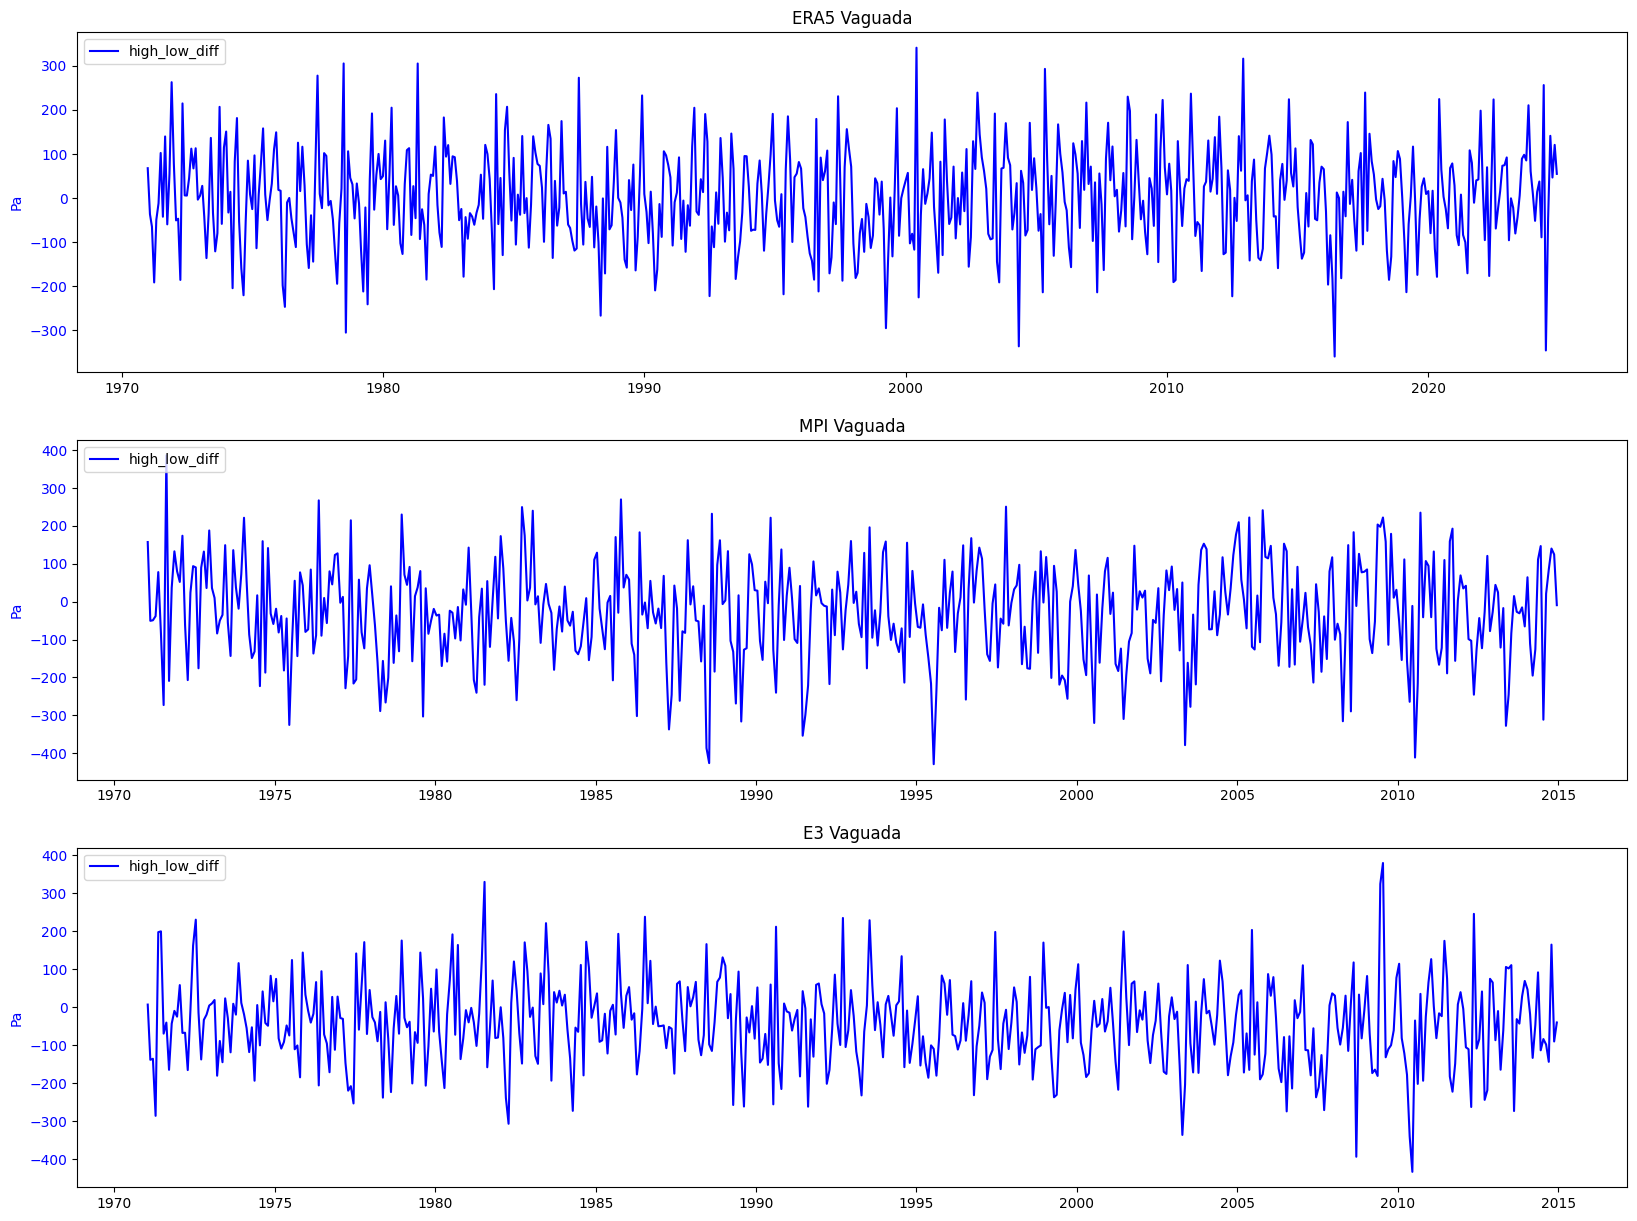

In [ ]:
# Create figure and base axis
fig, ax1 = plt.subplots(3, 1, figsize=(20, 15))

ax1 = ax1.flatten()

index1_era5 = mslp_indices_era5[0]
index2_era5 = mslp_indices_era5[1]
index3_era5 = mslp_indices_era5[2]

vaguada_era5 = mslp_indices_era5[0] - (mslp_indices_era5[1]+mslp_indices_era5[2])/2


# Plot first series
ax1[0].plot(index1_era5.time, vaguada_era5, color='blue', label='high_low_diff')
ax1[0].set_ylabel('Pa', color='blue')
ax1[0].tick_params(axis='y', labelcolor='blue')


ax1[0].set_title("ERA5 Vaguada")
ax1[0].legend(loc='upper left')

index1_mpi = mslp_indices_mpi_370[0]
index2_mpi = mslp_indices_mpi_370[1]
index3_mpi = mslp_indices_mpi_370[2]

vaguada_mpi = index1_mpi- (index2_mpi+index3_mpi)/2

# Plot first series
ax1[1].plot(index1_mpi.time, vaguada_mpi, color='blue', label='high_low_diff')
ax1[1].set_ylabel('Pa', color='blue')
ax1[1].tick_params(axis='y', labelcolor='blue')
ax1[1].set_title("MPI Vaguada")
ax1[1].legend(loc='upper left')

# index1_e3 = mslp_indices_e3[0]
# index2_e3 = mslp_indices_e3[1]
# index3_e3 = mslp_indices_e3[2]

# vaguada_e3 = index1_e3- (index2_e3+index3_e3)/2

# # Plot first series
# ax1[2].plot(index1_e3.time, vaguada_e3, color='blue', label='high_low_diff')
# ax1[2].set_ylabel('Pa', color='blue')
# ax1[2].tick_params(axis='y', labelcolor='blue')
# ax1[2].set_title("E3 Vaguada")
# ax1[2].legend(loc='upper left')

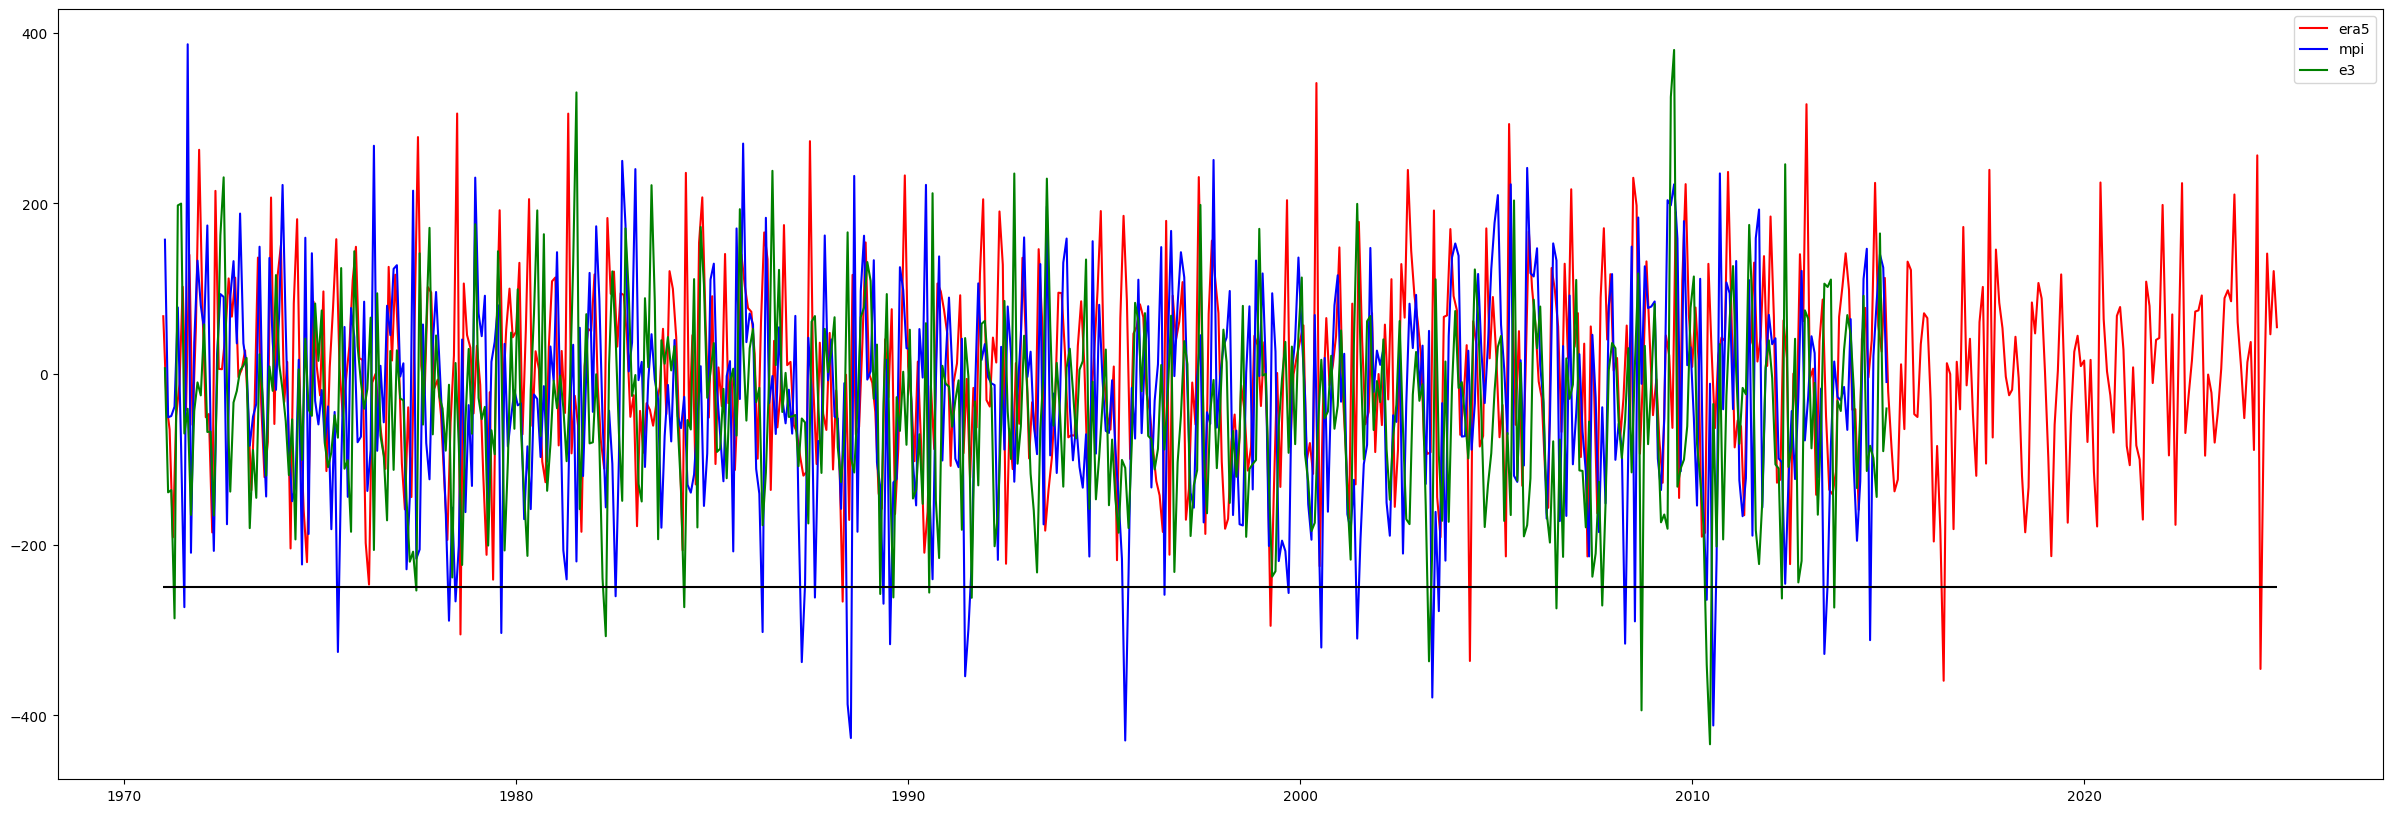

In [ ]:
fig, ax = plt.subplots(figsize=(30,10))

ax.plot(index1_era5.time, vaguada_era5, color='red', label='era5')
ax.plot(index1_mpi.time, vaguada_mpi, color='blue', label='mpi')
# ax.plot(index1_e3.time, vaguada_e3, color='green', label='e3')

ax.hlines([-250], index1_era5.time[0], index1_era5.time[-1], colors="black")
plt.legend()
plt.show()


In [ ]:
vaguada_era5_df = vaguada_era5.to_dataframe()
vaguada_mpi_df = vaguada_mpi.to_dataframe()
vaguada_e3_df = vaguada_e3.to_dataframe()

In [ ]:
print(f" Vaguada events ERA5: {vaguada_era5_df[vaguada_era5_df<-100].count()}/{vaguada_era5_df.count()}")

 Vaguada events ERA5: msl    114
dtype: int64/msl    648
dtype: int64


In [ ]:
print(f" Vaguada events MPI: {vaguada_mpi_df[vaguada_mpi_df<-100].count()}/{vaguada_mpi_df.count()}")

 Vaguada events MPI: psl    154
dtype: int64/psl    528
dtype: int64


In [ ]:
print(f" Vaguada events E3: {vaguada_e3_df[vaguada_e3_df<-100].count()}/{vaguada_e3_df.count()}")

 Vaguada events E3: psl    155
dtype: int64/psl    528
dtype: int64


### Wind features

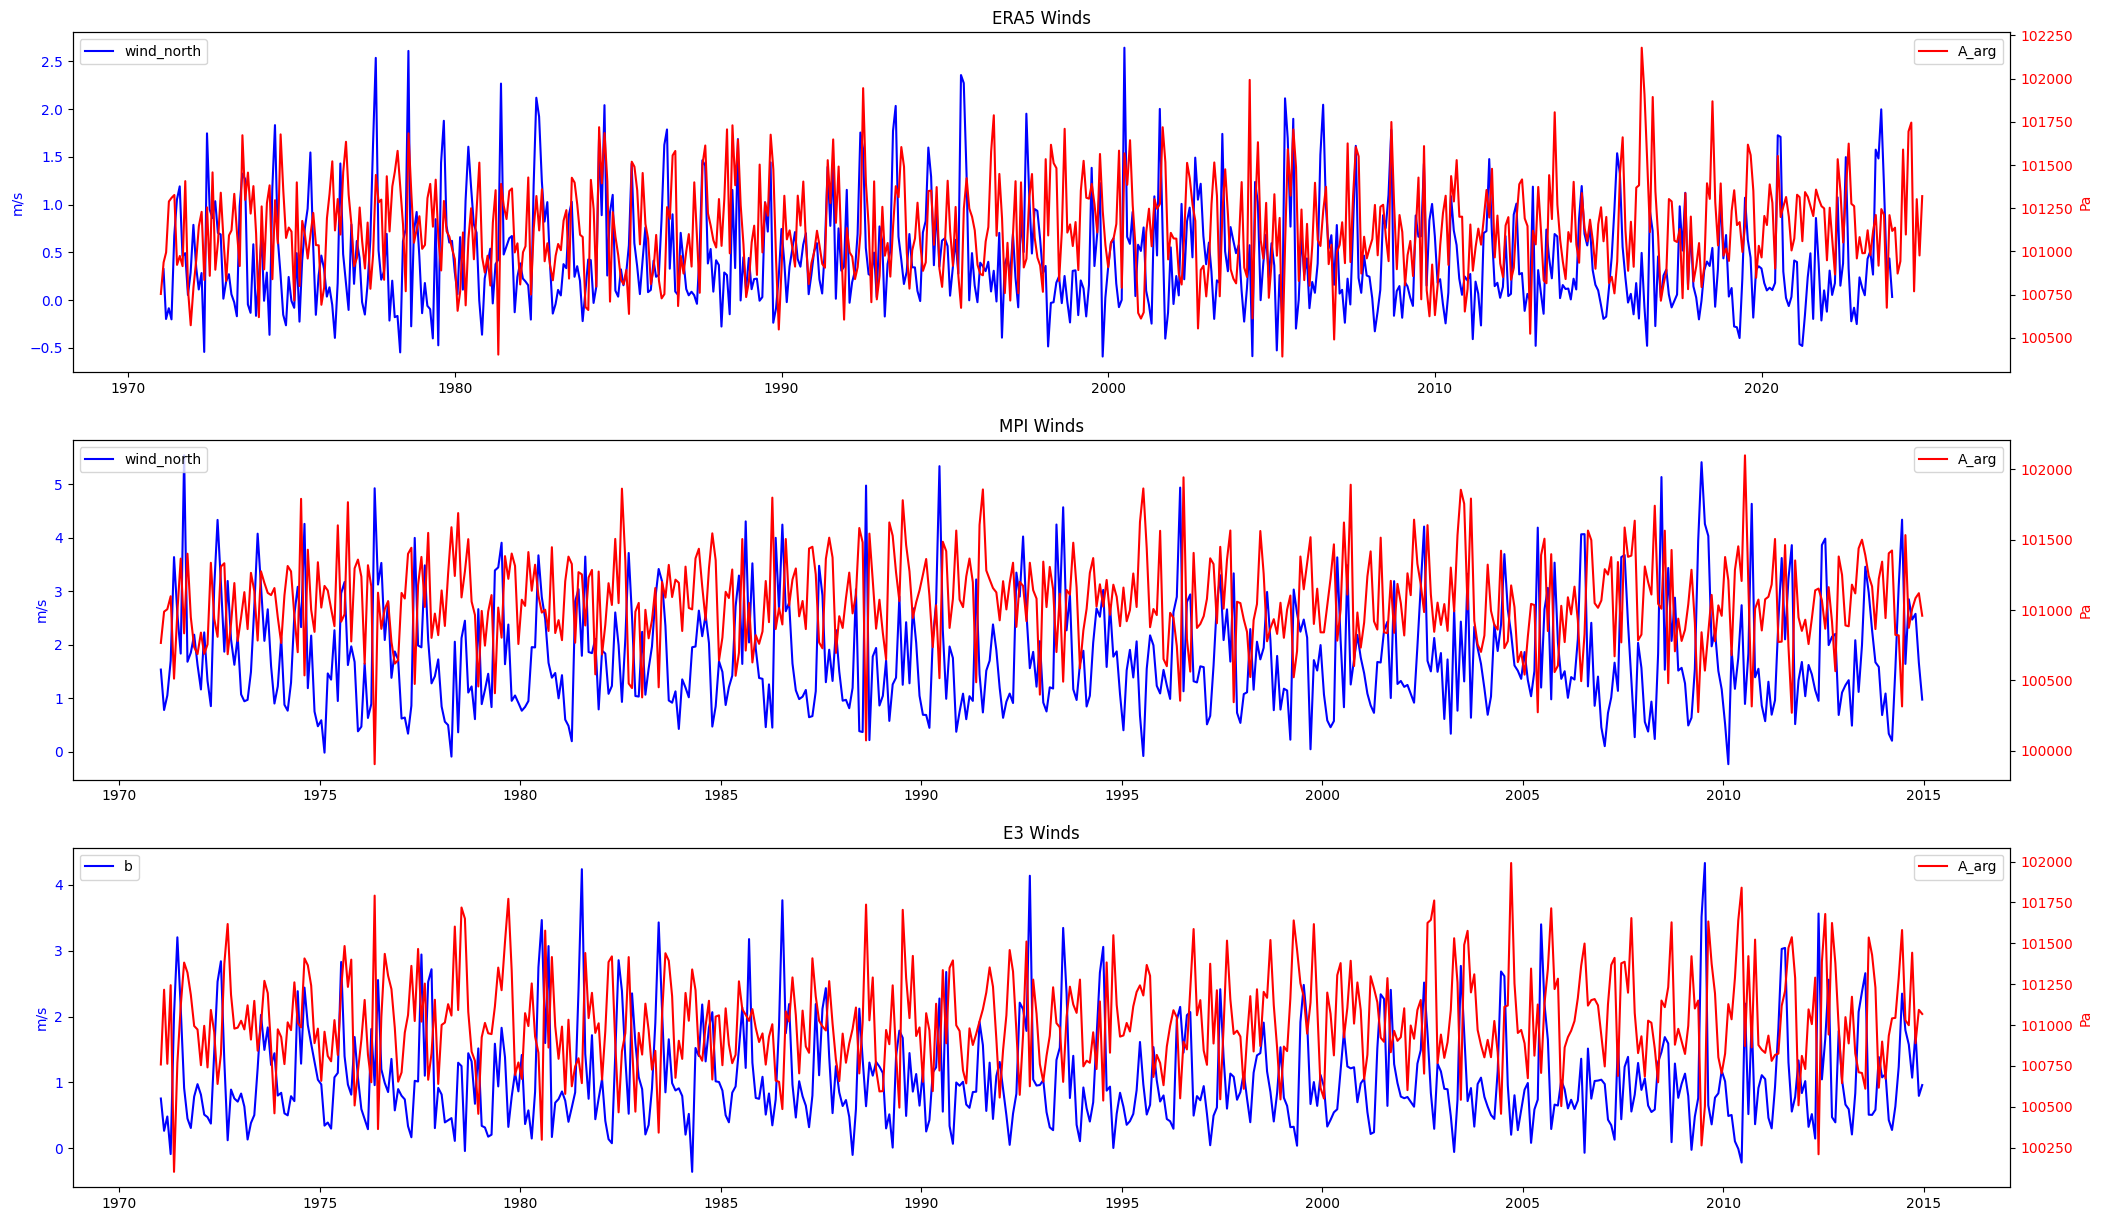

In [ ]:
# Create figure and base axis
fig, ax1 = plt.subplots(3, 1, figsize=(25, 15))

ax1 = ax1.flatten()

# Plot first series
ax1[0].plot(chile_wind_north_era5.time, chile_wind_north_era5, color='blue', label='wind_north')
ax1[0].set_ylabel('m/s', color='blue')
ax1[0].tick_params(axis='y', labelcolor='blue')

# Second Y-axis (right side)
ax2 = ax1[0].twinx()
ax2.plot(chile_wind_pressure_era5.time, chile_wind_pressure_era5, color='red', label='A_arg')
ax2.set_ylabel('Pa', color='red')
ax2.tick_params(axis='y', labelcolor='red')


ax1[0].set_title("ERA5 Winds")
ax1[0].legend(loc='upper left')
ax2.legend(loc='upper right')


# Plot first series
ax1[1].plot(chile_wind_north_mpi.time, chile_wind_north_mpi, color='blue', label='wind_north')
ax1[1].set_ylabel('m/s', color='blue')
ax1[1].tick_params(axis='y', labelcolor='blue')

# Second Y-axis (right side)
ax2 = ax1[1].twinx()
ax2.plot(chile_wind_pressure_mpi.time, chile_wind_pressure_mpi, color='red', label='A_arg')
ax2.set_ylabel('Pa', color='red')
ax2.tick_params(axis='y', labelcolor='red')


ax1[1].set_title("MPI Winds")
ax1[1].legend(loc='upper left')
ax2.legend(loc='upper right')

# Plot first series
ax1[2].plot(chile_wind_north_e3.time, chile_wind_north_e3, color='blue', label='b')
ax1[2].set_ylabel('m/s', color='blue')
ax1[2].tick_params(axis='y', labelcolor='blue')

# Second Y-axis (right side)
ax2 = ax1[2].twinx()
ax2.plot(chile_wind_pressure_e3.time, chile_wind_pressure_e3, color='red', label='A_arg')
ax2.set_ylabel('Pa', color='red')
ax2.tick_params(axis='y', labelcolor='red')


ax1[2].set_title("E3 Winds")
ax1[2].legend(loc='upper left')
ax2.legend(loc='upper right')

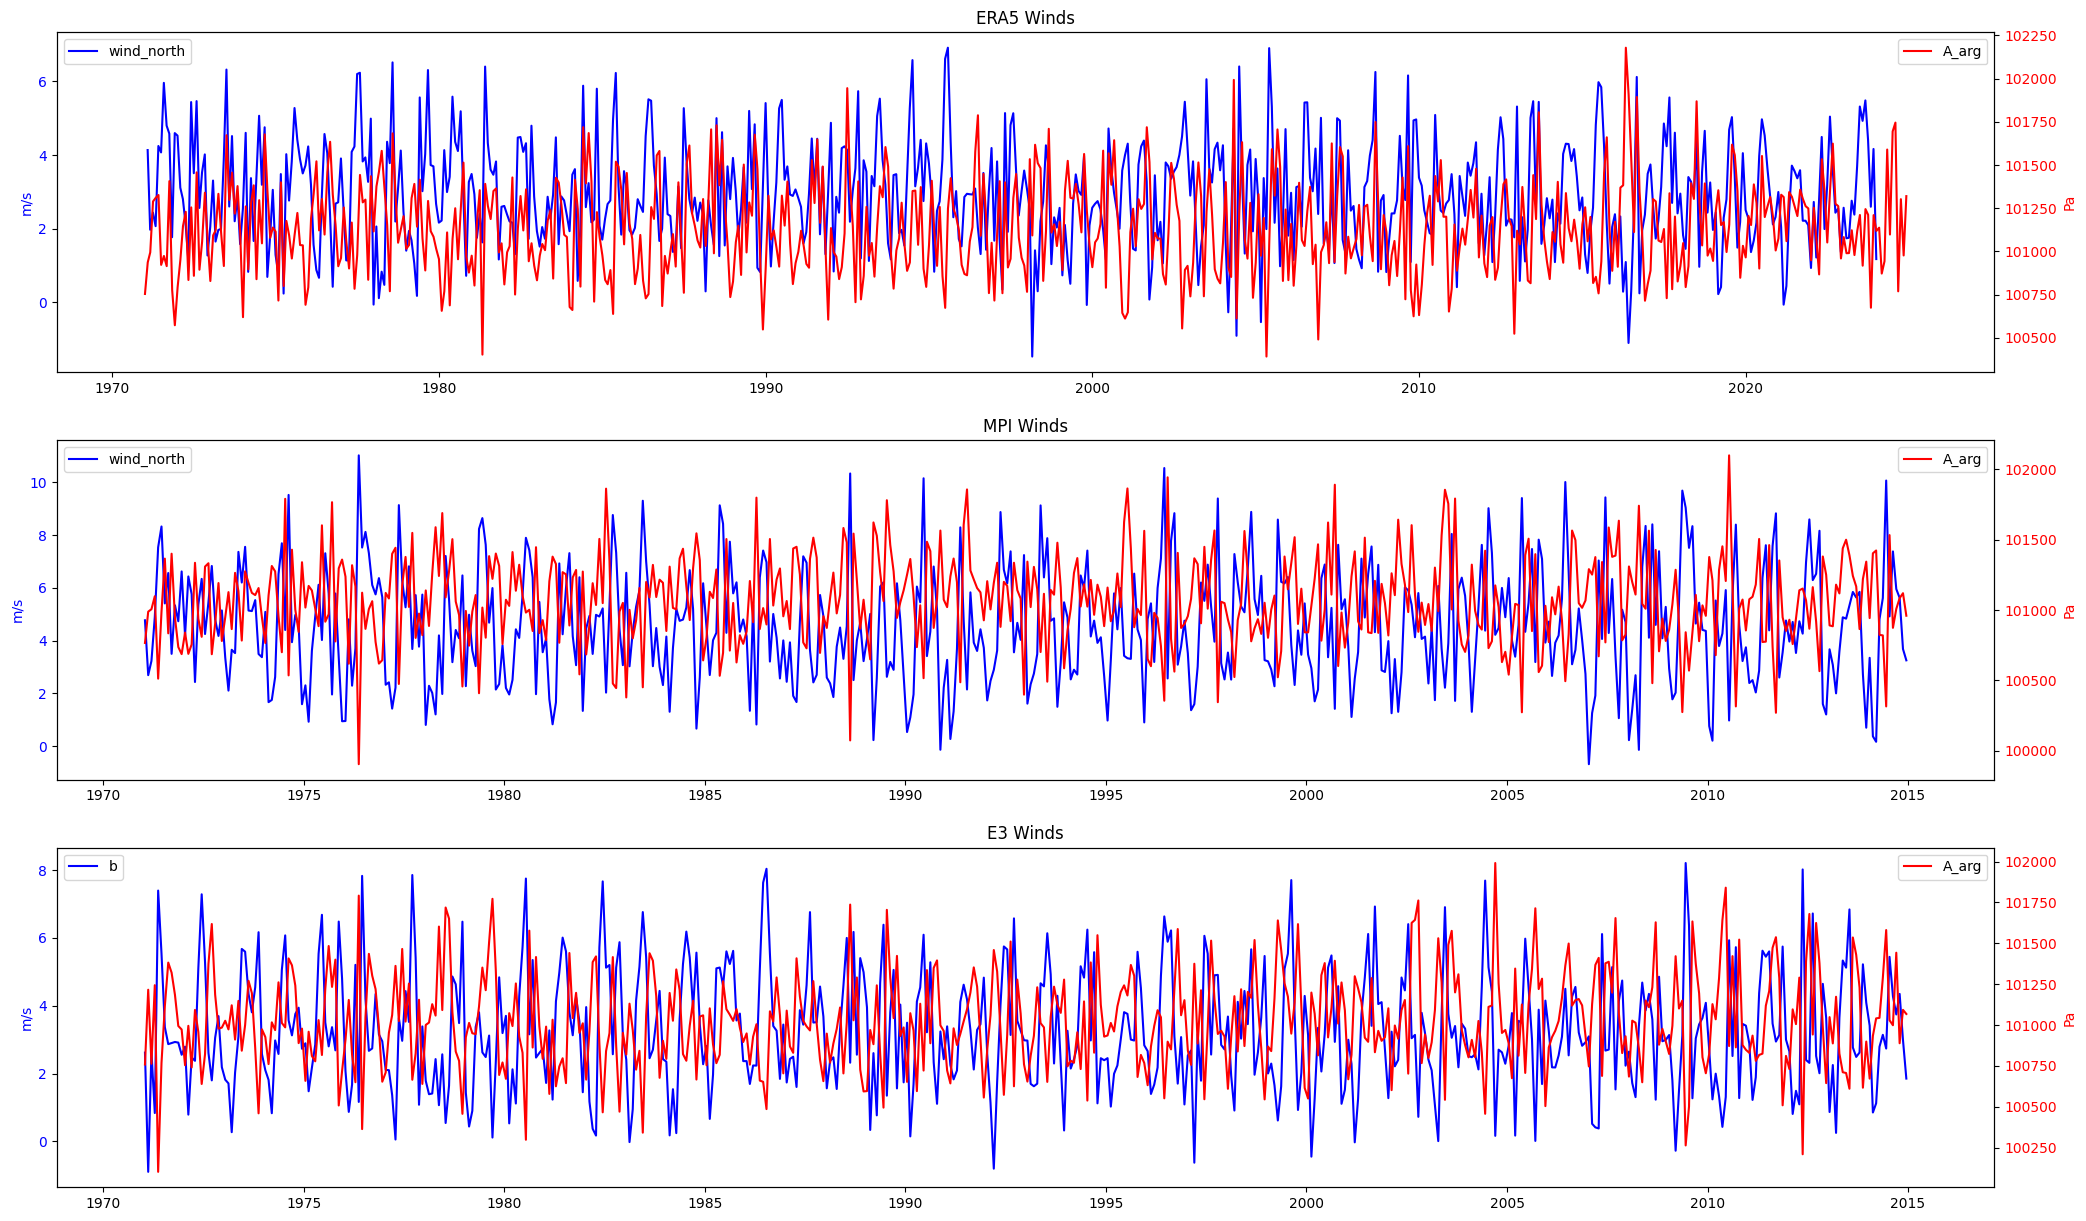

In [ ]:
# Create figure and base axis
fig, ax1 = plt.subplots(3, 1, figsize=(25, 15))

ax1 = ax1.flatten()

# Plot first series
ax1[0].plot(chile_wind_south_era5.time, chile_wind_south_era5, color='blue', label='wind_north')
ax1[0].set_ylabel('m/s', color='blue')
ax1[0].tick_params(axis='y', labelcolor='blue')

# Second Y-axis (right side)
ax2 = ax1[0].twinx()
ax2.plot(chile_wind_pressure_era5.time, chile_wind_pressure_era5, color='red', label='A_arg')
ax2.set_ylabel('Pa', color='red')
ax2.tick_params(axis='y', labelcolor='red')


ax1[0].set_title("ERA5 Winds")
ax1[0].legend(loc='upper left')
ax2.legend(loc='upper right')


# Plot first series
ax1[1].plot(chile_wind_south_mpi.time, chile_wind_south_mpi, color='blue', label='wind_north')
ax1[1].set_ylabel('m/s', color='blue')
ax1[1].tick_params(axis='y', labelcolor='blue')

# Second Y-axis (right side)
ax2 = ax1[1].twinx()
ax2.plot(chile_wind_pressure_mpi.time, chile_wind_pressure_mpi, color='red', label='A_arg')
ax2.set_ylabel('Pa', color='red')
ax2.tick_params(axis='y', labelcolor='red')


ax1[1].set_title("MPI Winds")
ax1[1].legend(loc='upper left')
ax2.legend(loc='upper right')

# Plot first series
ax1[2].plot(chile_wind_south_e3.time, chile_wind_south_e3, color='blue', label='b')
ax1[2].set_ylabel('m/s', color='blue')
ax1[2].tick_params(axis='y', labelcolor='blue')

# Second Y-axis (right side)
ax2 = ax1[2].twinx()
ax2.plot(chile_wind_pressure_e3.time, chile_wind_pressure_e3, color='red', label='A_arg')
ax2.set_ylabel('Pa', color='red')
ax2.tick_params(axis='y', labelcolor='red')


ax1[2].set_title("E3 Winds")
ax1[2].legend(loc='upper left')
ax2.legend(loc='upper right')

## Correlations between features 

In [ ]:
import pandas as pd

In [ ]:
df_era5 = pd.DataFrame()
df_era5["nino34"] = nino34_era5.get_index("SST")["sst"]
df_era5["nino12"] = nino12_era5.get_index("SST")["sst"]
df_era5["adv_chile"] = advection_indices_era5[0].get_index("ADV")["adv"]
df_era5["adv_blob"] = advection_indices_era5[1].get_index("ADV")["adv"]
df_era5["ocean_cyclone"] = ocean_cyclone_era5.get_index("MSL")["max_value"]
df_era5["vag_b"] = mslp_indices_era5[0].sel(time=slice("1972-01", "2022-12"))
df_era5["vag_A_cl"] = mslp_indices_era5[1].sel(time=slice("1972-01", "2022-12"))
df_era5["vag_A_arg"] = mslp_indices_era5[2].sel(time=slice("1972-01", "2022-12"))
df_era5["vag_index"] = vaguada_era5.sel(time=slice("1972-01", "2022-12"))
df_era5["wind_north"] = chile_wind_north_era5.sel(time=slice("1972-01", "2022-12"))
df_era5["wind_south"] = chile_wind_south_era5.sel(time=slice("1972-01", "2022-12"))
df_era5["wind_pressure"] = chile_wind_pressure_era5.sel(time=slice("1972-01", "2022-12"))
df_era5 = df_era5.loc[:"2014-12"]
df_era5

nino34    nino12   adv_chile    adv_blob  ocean_cyclone   
Date                                                                    
1972-01-01 -0.823776  0.258211 -241.696350  147.466187    -113.156250  \
1972-02-01 -0.209746  1.211111 -281.967712  246.995117     180.843750   
1972-03-01 -0.145999  1.638937  -46.104065  160.248169     324.960938   
1972-04-01  0.634867  1.843269  593.157959  647.693176     389.476562   
1972-05-01  1.080823  1.118457 -702.820923 -728.394653       6.843750   
...              ...       ...         ...         ...            ...   
2014-08-01  0.402116  0.010642 -160.015015 -431.599915      -8.296875   
2014-09-01  0.540523 -0.616034 -479.006714 -315.097717     400.664062   
2014-10-01  0.572214 -0.167428 -128.563721 -398.961517     314.187500   
2014-11-01  0.841199  0.183258  144.130188  340.057678     395.335938   
2014-12-01  0.798505 -0.066134  172.110718  -30.001770     261.679688   

                    vag_b       vag_A_cl      vag_A_arg   vag_index   
Date                                                                  
1972-01-01  101282.070312  101646.015625  100762.164062   77.976562  \
1972-02-01  101338.648438  101739.523438  101038.992188  -50.609375   
1972-03-01  101445.773438  101765.710938  101219.523438  -46.843750   
1972-04-01  101581.070312  101976.328125  101557.023438 -185.601562   
1972-05-01  101564.632812  101468.054688  101232.015625  214.601562   
...                   ...            ...            ...         ...   
2014-08-01  101772.968750  101895.640625  101571.023438   39.640625   
2014-09-01  101846.226562  101927.531250  101317.007812  223.960938   
2014-10-01  101655.281250  101985.843750  101211.281250   56.718750   
2014-11-01  101726.421875  102190.757812  101209.625000   26.234375   
2014-12-01  101568.960938  101932.476562  100980.218750  112.617188   

            wind_north  wind_south  wind_pressure  
Date                                               
1972-01-01    0.343053    3.111732  100793.679688  
1972-02-01    0.111314    2.801713  100951.968750  
1972-03-01    0.283165    2.100365  101146.656250  
1972-04-01   -0.543281    1.136184  101229.375000  
1972-05-01    1.746470    5.437986  100834.914062  
...                ...         ...            ...  
2014-08-01    0.572297    3.836788  101134.429688  
2014-09-01    0.772375    4.159916  101059.234375  
2014-10-01    0.312637    3.411253  101183.921875  
2014-11-01    0.160050    2.497150  101063.734375  
2014-12-01    0.101326    2.846465  100900.078125  

[516 rows x 12 columns]

In [ ]:
df_era5.corr().style.background_gradient(cmap='coolwarm').format("{:.3f}")

In [ ]:
df_e3 = pd.DataFrame()
df_e3["nino34"] = nino34_e3.get_index("TOS")["tos"]
df_e3["nino12"] = nino12_e3.get_index("TOS")["tos"]
df_e3["adv_chile"] = advection_indices_e3[0].get_index("ADV")["adv"]
df_e3["adv_blob"] = advection_indices_e3[1].get_index("ADV")["adv"]
df_e3["ocean_cyclone"] = ocean_cyclone_e3.get_index("psl")["max_value"]
df_e3["vag_b"] = mslp_indices_e3[0].sel(time=slice("1972-01", "2022-12"))
df_e3["vag_A_cl"] = mslp_indices_e3[1].sel(time=slice("1972-01", "2022-12"))
df_e3["vag_A_arg"] = mslp_indices_e3[2].sel(time=slice("1972-01", "2022-12"))
df_e3["vag_index"] = vaguada_e3.sel(time=slice("1972-01", "2022-12"))
df_e3["wind_north"] = chile_wind_north_e3.sel(time=slice("1972-01", "2022-12"))
df_e3["wind_south"] = chile_wind_south_e3.sel(time=slice("1972-01", "2022-12"))
df_e3["wind_pressure"] = chile_wind_pressure_e3.sel(time=slice("1972-01", "2022-12"))
df_e3

nino34    nino12   adv_chile    adv_blob  ocean_cyclone   
Date                                                                    
1972-01-01 -1.439209 -2.041687  159.701233   29.762451      94.468750  \
1972-02-01 -1.523590 -1.262146  191.510437   71.433838     100.242188   
1972-03-01 -1.401123 -1.172241 -306.925964 -228.888306     -45.445312   
1972-04-01 -1.508881 -1.018188   17.295959  232.112854     459.148438   
1972-05-01 -1.642853 -2.737366 -218.640869  620.405334     966.039062   
...              ...       ...         ...         ...            ...   
2014-08-01  0.486816  1.317169 -150.807373 -163.868073       1.398438   
2014-09-01  0.683929  1.391815   85.793579  153.435455     436.671875   
2014-10-01  0.987640  1.725433 -387.854126 -967.682617       5.203125   
2014-11-01  1.026306  1.766052  111.632202   27.510376     209.359375   
2014-12-01  0.968018  1.778290  339.695312   61.444702     458.460938   

                    vag_b       vag_A_cl      vag_A_arg   vag_index   
Date                                                                  
1972-01-01  101231.789062  101534.296875  100813.062500   58.109375  \
1972-02-01  101160.523438  101459.406250  100997.390625  -67.875000   
1972-03-01  101143.257812  101370.671875  101050.625000  -67.390625   
1972-04-01  101427.085938  101719.218750  101466.382812 -165.710938   
1972-05-01  101694.632812  101906.476562  101497.765625   -7.492188   
...                   ...            ...            ...         ...   
2014-08-01  101657.992188  101821.726562  101690.929688  -98.335938   
2014-09-01  101589.562500  101919.968750  101547.164062 -144.000000   
2014-10-01  101611.984375  101629.445312  101265.093750  164.718750   
2014-11-01  101409.265625  101857.132812  101142.187500  -90.390625   
2014-12-01  101353.328125  101727.382812  101059.984375  -40.359375   

            wind_north  wind_south  wind_pressure  
Date                                               
1972-01-01    0.814839    2.791353  100754.218750  
1972-02-01    0.511617    0.788483  100995.125000  
1972-03-01    0.473283    2.474383  100740.429688  
1972-04-01    0.375653    2.374184  101092.343750  
1972-05-01    1.453489    5.104896  100957.046875  
...                ...         ...            ...  
2014-08-01    1.574025    4.276847  100998.656250  
2014-09-01    1.072607    3.739749  101442.585938  
2014-10-01    1.755325    4.346091  100888.445312  
2014-11-01    0.795714    2.986335  101092.914062  
2014-12-01    0.960230    1.850568  101067.679688  

[516 rows x 12 columns]

In [ ]:
df_e3.corr().style.background_gradient(cmap='coolwarm').format("{:.3f}")

In [ ]:
df_mpi = pd.DataFrame()
df_mpi["nino34"] = nino34_mpi.get_index("TOS")["tos"]
df_mpi["nino12"] = nino12_mpi.get_index("TOS")["tos"]
df_mpi["adv_chile"] = advection_indices_mpi[0].get_index("ADV")["adv"]
df_mpi["adv_blob"] = advection_indices_mpi[1].get_index("ADV")["adv"]
df_mpi["ocean_cyclone"] = ocean_cyclone_mpi.get_index("psl")["max_value"]
df_mpi["vag_b"] = mslp_indices_mpi[0].sel(time=slice("1972-01", "2022-12"))
df_mpi["vag_A_cl"] = mslp_indices_mpi[1].sel(time=slice("1972-01", "2022-12"))
df_mpi["vag_A_arg"] = mslp_indices_mpi[2].sel(time=slice("1972-01", "2022-12"))
df_mpi["vag_index"] = vaguada_mpi.sel(time=slice("1972-01", "2022-12"))
df_mpi["wind_north"] = chile_wind_north_mpi.sel(time=slice("1972-01", "2022-12"))
df_mpi["wind_south"] = chile_wind_south_mpi.sel(time=slice("1972-01", "2022-12"))
df_mpi["wind_pressure"] = chile_wind_pressure_mpi.sel(time=slice("1972-01", "2022-12"))
df_mpi

nino34    nino12    adv_chile    adv_blob  ocean_cyclone   
Date                                                                     
1972-01-01  0.242004  0.627899  -571.502319  -29.021240      21.148438  \
1972-02-01  0.083130  0.089722 -1256.768311 -225.968018      67.960938   
1972-03-01 -0.252930  0.327728  -639.590942  259.046204      53.171875   
1972-04-01 -0.279694  0.567474   413.823914  280.003113     305.609375   
1972-05-01  0.196472  0.649841   106.006958 -697.628357     -66.515625   
...              ...       ...          ...         ...            ...   
2014-08-01 -0.005524  0.591492  -434.259277  223.499527     510.218750   
2014-09-01 -0.824371  0.464661  -317.133911  -27.354828     273.125000   
2014-10-01 -0.554718  0.440399  -156.592896 -259.521576     276.523438   
2014-11-01 -0.814575  0.364136   280.262756   98.955383     519.492188   
2014-12-01 -1.081207  0.255646  -105.130493   57.981812     119.601562   

                    vag_b       vag_A_cl      vag_A_arg   vag_index   
Date                                                                  
1972-01-01  101307.164062  101685.507812  100824.570312   52.125000  \
1972-02-01  101383.046875  101681.085938  100736.914062  174.046875   
1972-03-01  101384.960938  101802.585938  101090.562500  -61.617188   
1972-04-01  101446.859375  101859.046875  101449.070312 -207.203125   
1972-05-01  101419.585938  101460.601562  101331.367188   23.601562   
...                   ...            ...            ...         ...   
2014-08-01  101886.546875  102068.828125  101662.335938   20.968750   
2014-09-01  101715.515625  101980.273438  101280.695312   85.031250   
2014-10-01  101669.335938  101921.101562  101137.085938  140.242188   
2014-11-01  101717.203125  102076.125000  101108.679688  124.796875   
2014-12-01  101493.648438  101917.718750  101088.250000   -9.335938   

            wind_north  wind_south  wind_pressure  
Date                                               
1972-01-01    1.167606    4.178689  100839.585938  
1972-02-01    2.233993    6.433211  100688.835938  
1972-03-01    1.328079    5.760794  100755.632812  
1972-04-01    0.855498    2.428447  101334.960938  
1972-05-01    3.072577    5.364130  100938.296875  
...                ...         ...            ...  
2014-08-01    2.853229    7.383209  100873.625000  
2014-09-01    2.473511    5.955152  101007.843750  
2014-10-01    2.581248    5.621091  101084.382812  
2014-11-01    1.664591    3.679484  101119.335938  
2014-12-01    0.977903    3.250364  100959.453125  

[516 rows x 12 columns]

In [ ]:
df_mpi.corr().style.background_gradient(cmap='coolwarm').format("{:.3f}")

In [ ]:
vaguada_gfdl = mslp_indices_gfdl[0] - (mslp_indices_gfdl[1]+mslp_indices_gfdl[2])/2


In [ ]:
df_gfdl = pd.DataFrame()
df_gfdl["nino34"] = nino34_gfdl.get_index("TOS")["tos"]
df_gfdl["nino12"] = nino12_gfdl.get_index("TOS")["tos"]
df_gfdl["adv_chile"] = advection_indices_gfdl[0].get_index("ADV")["adv"]
df_gfdl["adv_blob"] = advection_indices_gfdl[1].get_index("ADV")["adv"]
df_gfdl["ocean_cyclone"] = ocean_cyclone_gfdl.get_index("psl")["max_value"]
df_gfdl["vag_b"] = mslp_indices_gfdl[0].sel(time=slice("1972-01", "2022-12"))
df_gfdl["vag_A_cl"] = mslp_indices_gfdl[1].sel(time=slice("1972-01", "2022-12"))
df_gfdl["vag_A_arg"] = mslp_indices_gfdl[2].sel(time=slice("1972-01", "2022-12"))
vaguada_gfdl = mslp_indices_gfdl[0] - (mslp_indices_gfdl[1]+mslp_indices_gfdl[2])/2

df_gfdl["vag_index"] = vaguada_gfdl.sel(time=slice("1972-01", "2022-12"))
df_gfdl["wind_north"] = chile_wind_north_gfdl.sel(time=slice("1972-01", "2022-12"))
df_gfdl["wind_south"] = chile_wind_south_gfdl.sel(time=slice("1972-01", "2022-12"))
df_gfdl["wind_pressure"] = chile_wind_pressure_gfdl.sel(time=slice("1972-01", "2022-12"))
df_gfdl

nino34    nino12    adv_chile    adv_blob  ocean_cyclone   
Date                                                                     
1972-01-01  0.595734  0.577118    83.581299  -62.079712      45.804688  \
1972-02-01  0.808014 -0.337341  -391.634521  -64.022949     600.226562   
1972-03-01  0.819427 -0.085846   523.274658  591.116211     558.585938   
1972-04-01  0.149292 -0.501862    -2.770996  362.421448     123.812500   
1972-05-01  0.097961 -0.848297  -582.509277 -309.904907      77.148438   
...              ...       ...          ...         ...            ...   
2014-08-01 -0.107056  0.407410 -1137.921875 -216.727905     300.046875   
2014-09-01 -0.458740  0.063538   329.440918  -10.944122     740.703125   
2014-10-01 -0.800446 -0.666748  -193.874634  187.613861     321.570312   
2014-11-01 -1.018646 -0.285004   -33.143555  106.839539     660.046875   
2014-12-01 -1.050903 -0.068268   945.172852  282.009888    1132.007812   

                    vag_b       vag_A_cl      vag_A_arg   vag_index   
Date                                                                  
1972-01-01  101226.164062  101619.914062  100804.062500   14.179688  \
1972-02-01  101299.359375  101680.359375  100929.992188   -5.812500   
1972-03-01  101288.570312  101734.765625  101314.148438 -235.882812   
1972-04-01  101397.875000  101818.015625  101511.632812 -266.953125   
1972-05-01  101582.929688  101601.718750  101418.812500   72.664062   
...                   ...            ...            ...         ...   
2014-08-01  101900.203125  101957.546875  101591.164062  125.843750   
2014-09-01  101756.585938  101984.101562  101619.875000  -45.398438   
2014-10-01  101726.804688  102186.078125  101498.000000 -115.234375   
2014-11-01  101465.328125  101938.359375  100874.773438   58.765625   
2014-12-01  101321.859375  101888.023438  100936.500000  -90.406250   

            wind_north  wind_south  wind_pressure  
Date                                               
1972-01-01    0.588275    3.725543  100800.070312  
1972-02-01    0.979875    4.116530  100821.148438  
1972-03-01    0.139273    1.004456  101149.031250  
1972-04-01    0.740167    3.097520  101133.898438  
1972-05-01    2.612008    8.415719  100360.492188  
...                ...         ...            ...  
2014-08-01    4.143603    9.753816  100699.046875  
2014-09-01    1.234612    1.965207  101698.125000  
2014-10-01    0.706054    4.238015  101201.710938  
2014-11-01    1.163130    4.083879  100962.093750  
2014-12-01    0.738497    1.812586  101126.281250  

[516 rows x 12 columns]

In [ ]:
df_gfdl.corr().style.background_gradient(cmap='coolwarm').format("{:.3f}")

In [ ]:
df_inm = pd.DataFrame()
df_inm["nino34"] = nino34_inm.get_index("TOS")["tos"]
df_inm["nino12"] = nino12_inm.get_index("TOS")["tos"]
df_inm["adv_chile"] = advection_indices_inm[0].get_index("ADV")["adv"]
df_inm["adv_blob"] = advection_indices_inm[1].get_index("ADV")["adv"]
df_inm["ocean_cyclone"] = ocean_cyclone_inm.get_index("psl")["max_value"]
df_inm["vag_b"] = mslp_indices_inm[0].sel(time=slice("1972-01", "2022-12"))
df_inm["vag_A_cl"] = mslp_indices_inm[1].sel(time=slice("1972-01", "2022-12"))
df_inm["vag_A_arg"] = mslp_indices_inm[2].sel(time=slice("1972-01", "2022-12"))
vaguada_inm = mslp_indices_inm[0] - (mslp_indices_inm[1]+mslp_indices_inm[2])/2

df_inm["vag_index"] = vaguada_inm.sel(time=slice("1972-01", "2022-12"))
df_inm["wind_north"] = chile_wind_north_inm.sel(time=slice("1972-01", "2022-12"))
df_inm["wind_south"] = chile_wind_south_inm.sel(time=slice("1972-01", "2022-12"))
df_inm["wind_pressure"] = chile_wind_pressure_inm.sel(time=slice("1972-01", "2022-12"))
df_inm

nino34    nino12   adv_chile    adv_blob  ocean_cyclone   
Date                                                                    
1972-01-01 -1.017059 -0.377441   67.319855  378.011780     175.851562  \
1972-02-01 -0.928223 -0.431580 -118.945984  315.487183     104.601562   
1972-03-01 -0.838959 -0.384918   36.429718  -98.434082     109.429688   
1972-04-01 -0.673035 -0.347839  424.170593  284.822998     431.656250   
1972-05-01 -0.294525 -0.395844  120.798218 -221.527069     219.859375   
...              ...       ...         ...         ...            ...   
2014-08-01 -0.170990 -0.715790  377.704102 -528.421753     662.117188   
2014-09-01  0.005951 -0.359436   -7.403687 -223.717361     472.695312   
2014-10-01  0.312622 -0.091370  203.221252 -188.137604     156.296875   
2014-11-01  0.356079 -0.015656   34.174896  381.665771     188.671875   
2014-12-01 -0.215729  0.088654  226.725220  -81.631287     389.062500   

                    vag_b       vag_A_cl      vag_A_arg   vag_index   
Date                                                                  
1972-01-01  100987.648438  101429.484375  100584.453125  -19.320312  \
1972-02-01  100983.117188  101460.945312  100762.117188 -128.414062   
1972-03-01  101186.820312  101467.765625  100900.984375    2.445312   
1972-04-01  101443.625000  101758.585938  101689.890625 -280.609375   
1972-05-01  101556.656250  101645.984375  101592.437500  -62.554688   
...                   ...            ...            ...         ...   
2014-08-01  101698.570312  101777.593750  101745.781250  -63.117188   
2014-09-01  101664.750000  101862.976562  101441.453125   12.531250   
2014-10-01  101532.679688  101866.734375  101305.960938  -53.664062   
2014-11-01  101307.242188  101735.984375  101080.359375 -100.929688   
2014-12-01  101252.875000  101612.851562  100854.164062   19.367188   

            wind_north  wind_south  wind_pressure  
Date                                               
1972-01-01    1.148334    1.989370  100916.468750  
1972-02-01    0.792003    2.273133  100940.203125  
1972-03-01    0.809552    2.596392  100973.656250  
1972-04-01    0.751374    2.055868  101485.421875  
1972-05-01    3.524631    6.022384  101070.453125  
...                ...         ...            ...  
2014-08-01    3.268358    6.085255  101221.539062  
2014-09-01    2.744889    5.722103  100886.515625  
2014-10-01    0.962413    3.098046  101341.968750  
2014-11-01    0.932741    2.561801  101087.898438  
2014-12-01    0.724250    1.661818  101078.695312  

[516 rows x 12 columns]

In [ ]:
df_inm.corr().style.background_gradient(cmap='coolwarm').format("{:.3f}")

In [ ]:
def flatten_corr_matrix(corr_df):
    return corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(bool)).stack()

model_corrs = {}

# Assume these are your correlation matrices
model_dfs = {
    'ERA5': df_era5.corr(),
    'EC-Earth3': df_e3.corr(),
    'MPI-ESM1-2-HR': df_mpi.corr(),
    'GFDL-ESM4': df_gfdl.corr(),
    'INM-CM4-8': df_inm.corr(),
    # Add more as needed
}

for model_name, corr_df in model_dfs.items():
    model_corrs[model_name] = flatten_corr_matrix(corr_df)

# Combine into one DataFrame
corr_comparison_df = pd.DataFrame(model_corrs).T  # Models as rows, correlations as columns
corr_comparison_df

nino34                                                         
                 nino12 adv_chile  adv_blob ocean_cyclone     vag_b  vag_A_cl   
ERA5           0.445479 -0.088206 -0.142572     -0.123725 -0.098050 -0.147476  \
EC-Earth3      0.785400 -0.022613 -0.090522     -0.046007 -0.073806 -0.054857   
MPI-ESM1-2-HR  0.608034  0.013073 -0.061961     -0.032027 -0.127313 -0.114421   
GFDL-ESM4      0.690258 -0.033231 -0.204331     -0.093489 -0.068549 -0.124834   
INM-CM4-8      0.503204 -0.000096 -0.096071     -0.042789 -0.047547 -0.065657   

                                                         ... vag_A_arg   
              vag_A_arg vag_index wind_north wind_south  ... vag_index   
ERA5          -0.036129  0.016050   0.119064   0.059257  ... -0.541577  \
EC-Earth3     -0.032794 -0.039708   0.062188   0.006103  ... -0.467053   
MPI-ESM1-2-HR -0.026558 -0.056202   0.025896  -0.006699  ... -0.693481   
GFDL-ESM4     -0.017898  0.013926   0.078667   0.003383  ... -0.418267   
INM-CM4-8     -0.035014  0.007983  -0.021195  -0.034590  ... -0.357846   

                                                   vag_index              
              wind_north wind_south wind_pressure wind_north wind_south   
ERA5            0.068012   0.008904      0.698583   0.602422   0.525908  \
EC-Earth3       0.109006   0.124442      0.657687   0.715667   0.575865   
MPI-ESM1-2-HR   0.151972   0.119344      0.580389   0.498750   0.430291   
GFDL-ESM4       0.273743   0.195436      0.422712   0.657030   0.568546   
INM-CM4-8       0.546522   0.693199     -0.088235   0.453275   0.253775   

                            wind_north                  wind_south  
              wind_pressure wind_south wind_pressure wind_pressure  
ERA5              -0.604748   0.788511     -0.330746     -0.569155  
EC-Earth3         -0.668433   0.795814     -0.371429     -0.527864  
MPI-ESM1-2-HR     -0.762737   0.842332     -0.489623     -0.656430  
GFDL-ESM4         -0.676878   0.805152     -0.495511     -0.711221  
INM-CM4-8         -0.537303   0.926251     -0.728991     -0.726395  

[5 rows x 66 columns]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

diff_df = corr_comparison_df.subtract(corr_comparison_df.loc['ERA5'])

diff_df

nino34                                                         
                 nino12 adv_chile  adv_blob ocean_cyclone     vag_b  vag_A_cl   
ERA5           0.000000  0.000000  0.000000      0.000000  0.000000  0.000000  \
EC-Earth3      0.339921  0.065593  0.052050      0.077718  0.024244  0.092619   
MPI-ESM1-2-HR  0.162555  0.101278  0.080611      0.091698 -0.029263  0.033055   
GFDL-ESM4      0.244779  0.054974 -0.061759      0.030236  0.029501  0.022642   
INM-CM4-8      0.057725  0.088109  0.046501      0.080936  0.050503  0.081819   

                                                         ... vag_A_arg   
              vag_A_arg vag_index wind_north wind_south  ... vag_index   
ERA5           0.000000  0.000000   0.000000   0.000000  ...  0.000000  \
EC-Earth3      0.003335 -0.055757  -0.056876  -0.053154  ...  0.074524   
MPI-ESM1-2-HR  0.009571 -0.072252  -0.093169  -0.065956  ... -0.151904   
GFDL-ESM4      0.018231 -0.002123  -0.040397  -0.055874  ...  0.123310   
INM-CM4-8      0.001115 -0.008067  -0.140260  -0.093847  ...  0.183731   

                                                   vag_index              
              wind_north wind_south wind_pressure wind_north wind_south   
ERA5            0.000000   0.000000      0.000000   0.000000   0.000000  \
EC-Earth3       0.040994   0.115538     -0.040896   0.113245   0.049957   
MPI-ESM1-2-HR   0.083960   0.110441     -0.118194  -0.103673  -0.095618   
GFDL-ESM4       0.205731   0.186532     -0.275872   0.054608   0.042638   
INM-CM4-8       0.478510   0.684295     -0.786818  -0.149147  -0.272134   

                            wind_north                  wind_south  
              wind_pressure wind_south wind_pressure wind_pressure  
ERA5               0.000000   0.000000      0.000000      0.000000  
EC-Earth3         -0.063685   0.007303     -0.040683      0.041291  
MPI-ESM1-2-HR     -0.157989   0.053821     -0.158877     -0.087275  
GFDL-ESM4         -0.072130   0.016642     -0.164765     -0.142067  
INM-CM4-8          0.067445   0.137741     -0.398245     -0.157240  

[5 rows x 66 columns]

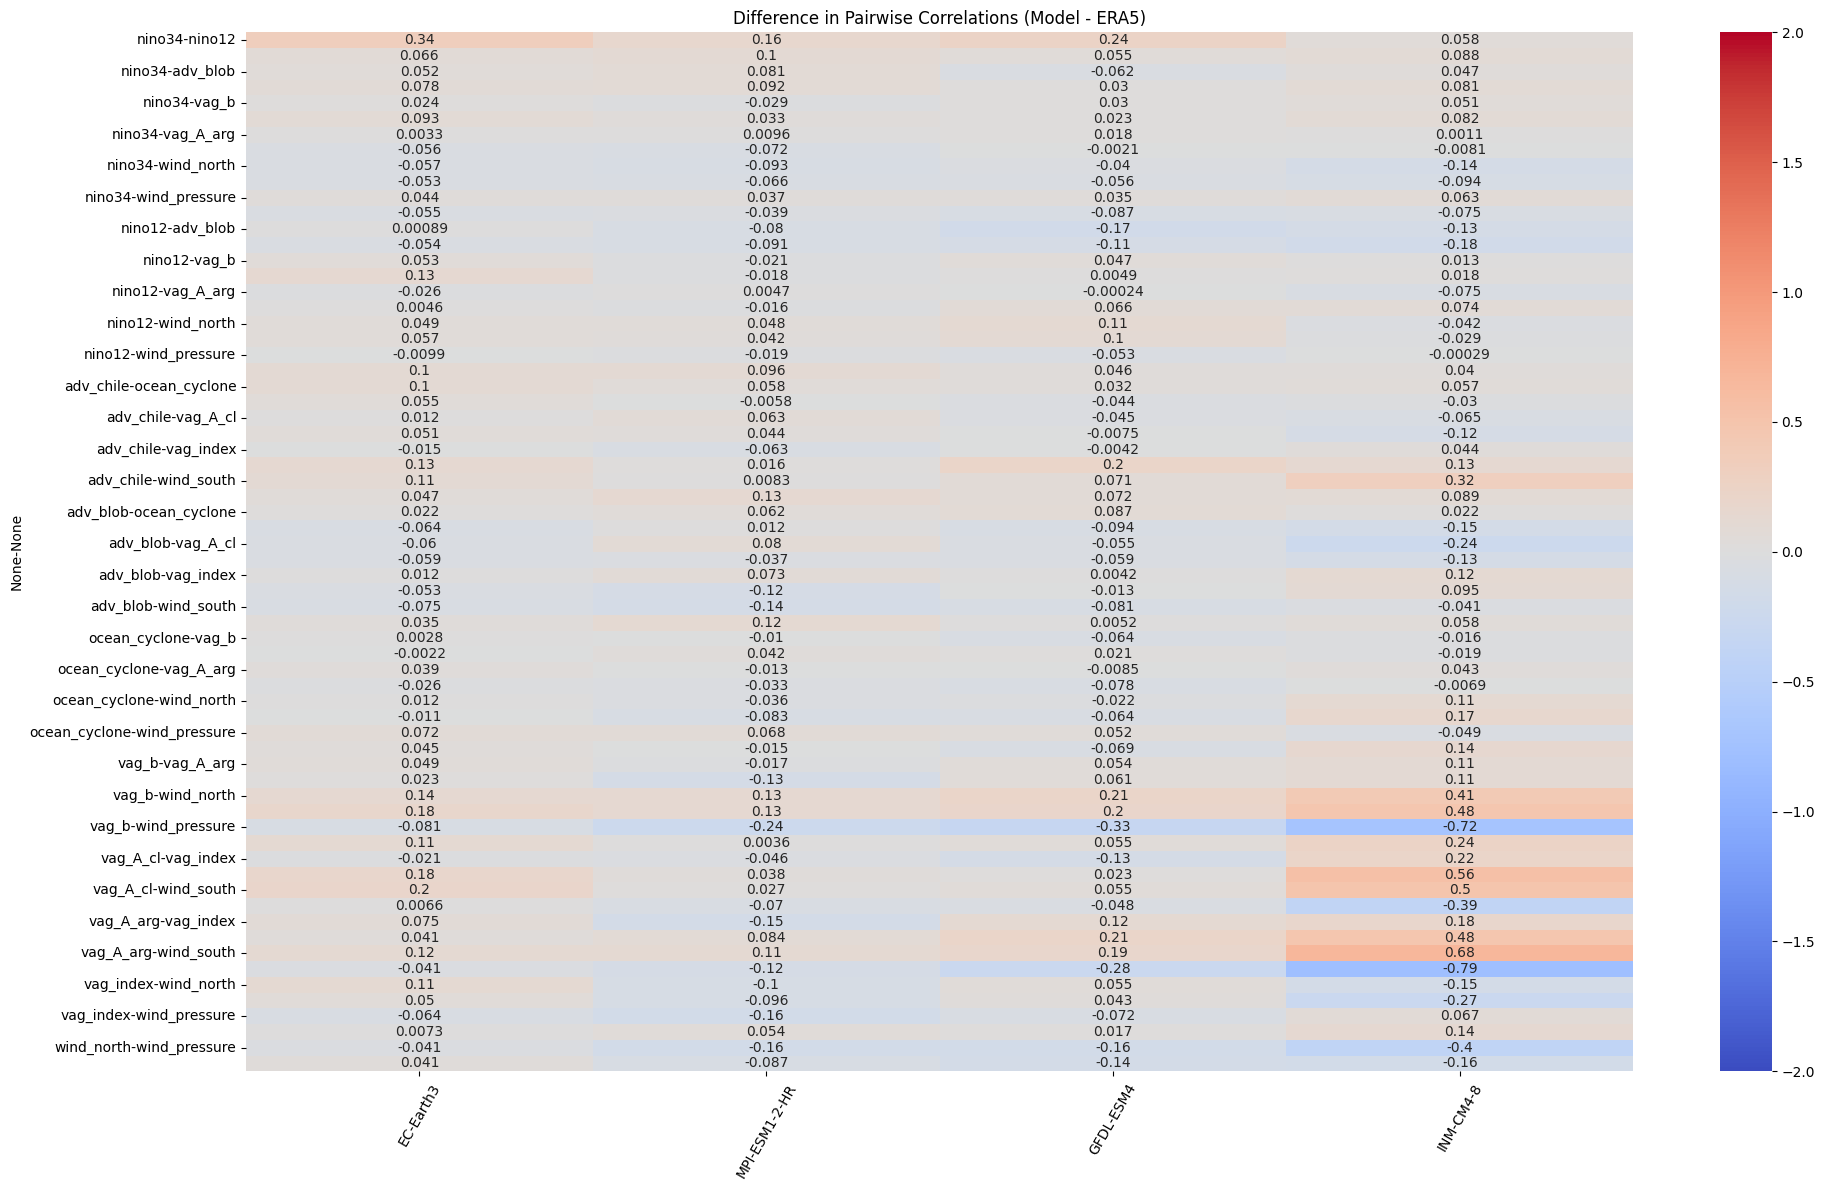

In [ ]:
plt.figure(figsize=(20, 12))
sns.heatmap(diff_df.drop('ERA5').T, annot=True, center=0, cmap='coolwarm', vmin=-2, vmax=2)
plt.xticks(rotation=60)
plt.title('Difference in Pairwise Correlations (Model - ERA5)')
plt.tight_layout()
plt.show()

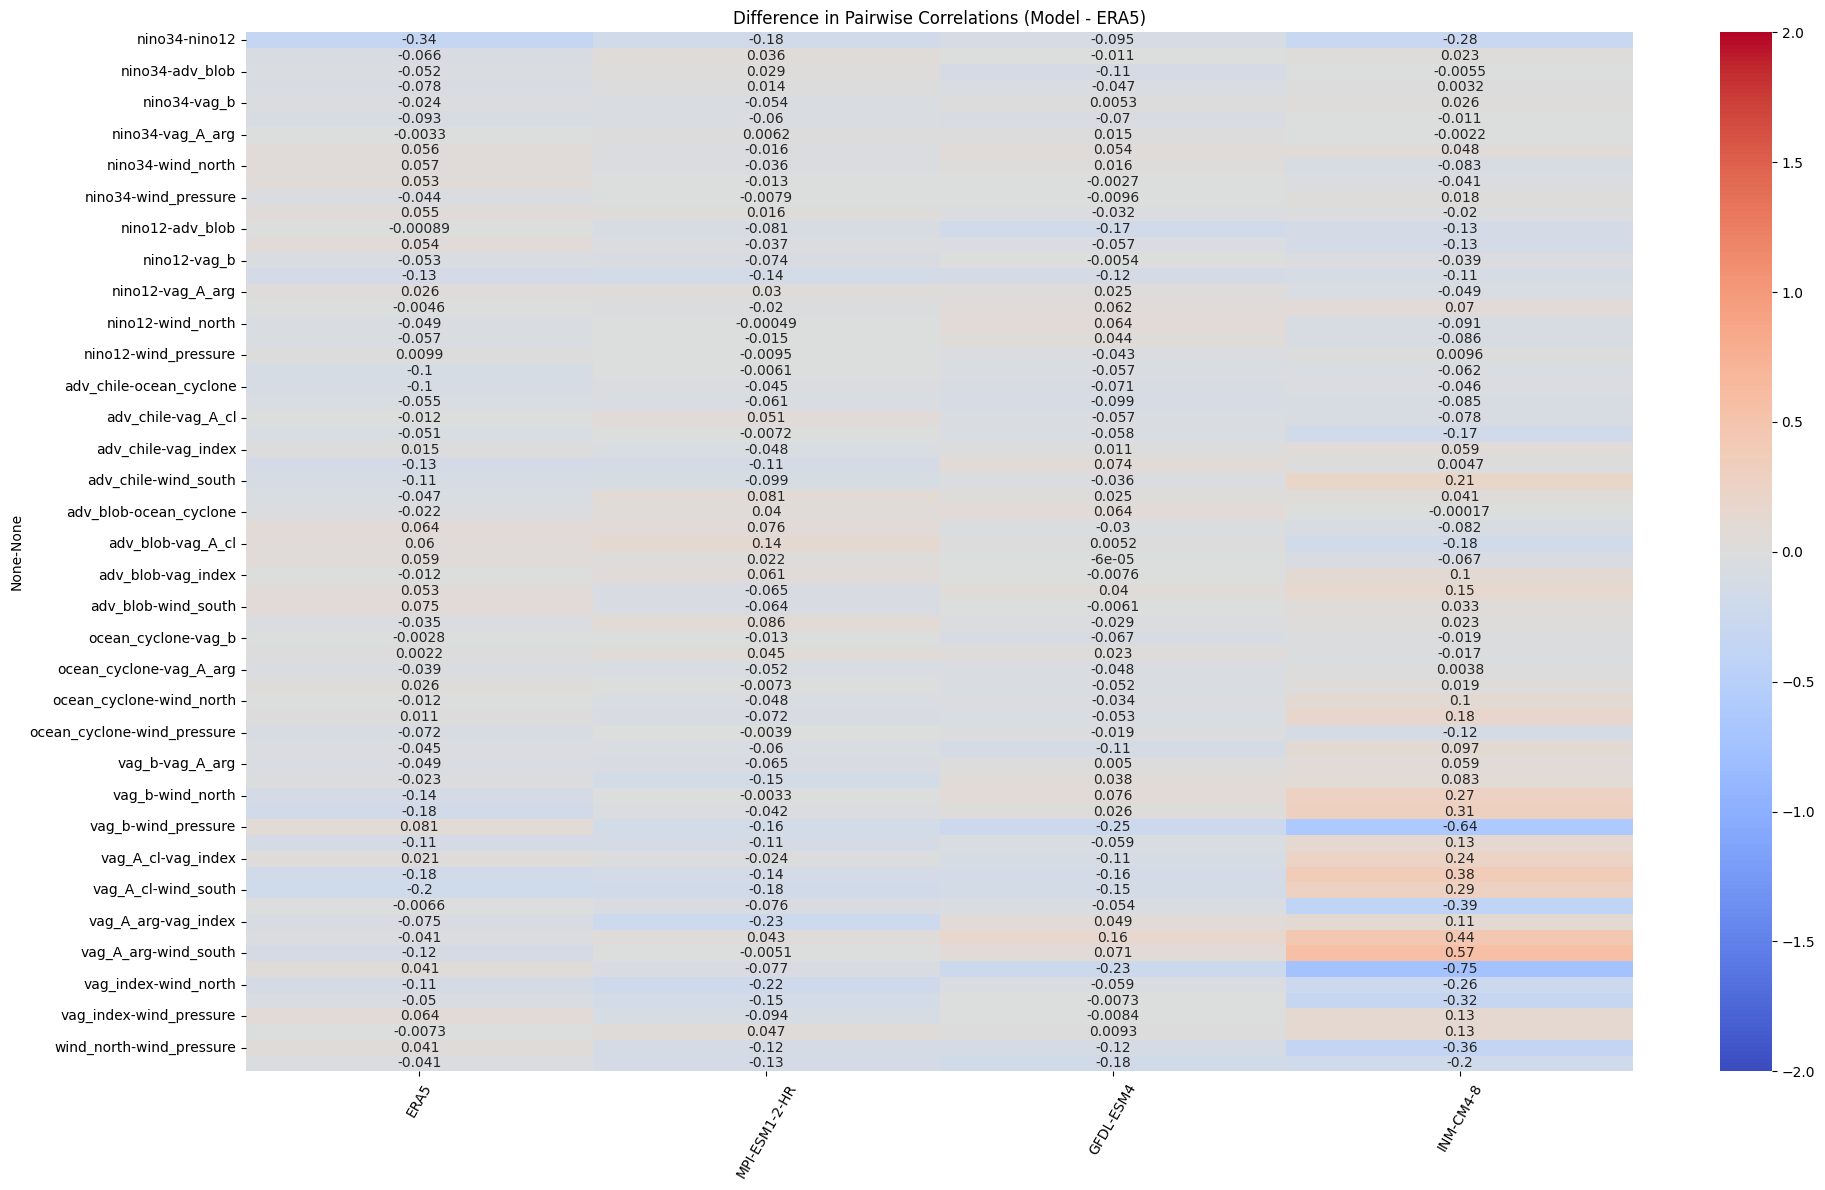

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

diff_df = corr_comparison_df.subtract(corr_comparison_df.loc['EC-Earth3'])

diff_df
plt.figure(figsize=(20, 12))
sns.heatmap(diff_df.drop('EC-Earth3').T, annot=True, center=0, cmap='coolwarm', vmin=-2, vmax=2)
plt.xticks(rotation=60)
plt.title('Difference in Pairwise Correlations (Model - ERA5)')
plt.tight_layout()
plt.show()